# Anime Classifier with Naïve Bayes
## Goal
Classify animes using their synopses into genres.
We would like to have an accuracy per genre of at least 80%. It means that, for a given genre, at least 80% of animes were correctly assigned their presence or absence of this genre. We will not define our accuracy has the percentage of animes for which we guess perfectly the presence and absence of all the genres, this would be extremely hard to accomplish with this algorithm.

## Steps
* Fetch anime data using an API
* Parse this data into class instances to facilitate processing
* Create a dataframe using our data, adding, for each word of the vocabulary, its number of occurences in each synopsis
* Implement the Multinomial Naïve Bayes algorithm -> calculate constants + classify
* Compute the accuracy in details
* Analyse & Visualize these accuracies
* Interpret our results

## Imports & Constants
We start by importing what we will need, as well as declaring some constants:

In [90]:
import requests
import json
import numpy as np
import pandas as pd
import time
import re
import os.path
from os import path
# makes it so that Jupyter displays the return values, even when they are not at the very end of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 50)

class Constants:
    FORCE_API_GET = False
    FORCE_COMPUTE_PARAMETERS = False
#     ANIMES_CSV_FILENAME = "animes_from_api.csv"
    ANIMES_CSV_FILENAME = "animes_from_api_more.csv"
    PARAMETERS_FILENAME = "parameters_all_genres_one_page.json"
    PARAMETERS_NO_FILENAME = "parameters_no_all_genres_one_page.json"
    INCLUDE_NSFW_GENRES = False   # Would only ignore them in the accuracy per genre analysis step

In [2]:
genres_name = {
    4: "Comedy",
    8: "Drama"
}
genres={'Action','Adventure','Cars','Comedy','Dementia','Demons','Drama','Ecchi','Fantasy'
        ,'Game','Harem','Hentai','Historical','Horror','Josei','Kids','Magic','Martial Arts'
        ,'Mecha','Military','Music','Mystery','Parody','Police','Psychological','Romance',
        'Samurai','School','Sci-Fi','Seinen','Shoujo','Shoujo Ai','Shounen','Shounen Ai',
        'Slice of Life','Space','Sports','Super Power','Supernatural','Thriller','Vampire','Yaoi','Yuri'}
genres_sfw = [g for g in genres if g not in ["Shoujo Ai", "Yuri", "Hentai", "Yaoi", "Shounen Ai", "Ecchi", "Harem"]]
selected_genres = genres if Constants.INCLUDE_NSFW_GENRES else genres_sfw

## Fetching Anime Data using an API
In order to reach our goal, we first need to collect our data. We could either find a database or csv file, or we could use an API.
Using an API will allow us to update our data as new animes air. I opted for an API as I wanted to practice using them.


The API we will use is [Jikan](https://jikan.docs.apiary.io/), an unofficial API for the website [MyAnimeList](https://myanimelist.net/).
It does no require any authentication.

The only type of request we will use fetches the most popular animes of a specific genre, divided by pages of 100 animes ([doc](https://jikan.docs.apiary.io/#reference/0/genre)).
As we want to guarantee having animes of all genres, we will request the first page of each genre.

In [3]:
# GET request to get the first page of animes of a genre
def request_genre(genre_id, page=1):
    url = "https://api.jikan.moe/v3/genre/anime/" + str(genre_id) + "/" + str(page)
    return requests.get(url).json()

### Parsing the data
The dictionary we get contains a lot of data we don't need. We will isolate the data about the animes themselves with the 'anime' key, where we find a list of animes as dictionnaries.

Each anime dictionary has 3 keys we are interested in:
* 'title': string
* 'synopsis': string
* 'genres': list of strings

In [4]:
response = request_genre(1, 1)

# In this example we will extract the title, synopsis and genres of the first anime
anime_dictionaries = response["anime"]
anime_1 = anime_dictionaries[0]
anime_1["title"]
anime_1["synopsis"]
anime_1["genres"]

# We get genres as a list of dictionaries, each dictionary having several keys.
# The name of the genre is the only one we are interested in.
def simplify_genres(genres_dictionaries):
    return [genre_dictionary["name"] for genre_dictionary in genres_dictionaries]  

# the genres values are dictionary themselves, so we will only key the value at the key "name" for each one
simplify_genres(anime_1["genres"])

'Shingeki no Kyojin'

"Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.\r\n\r\nAfter witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Ky

[{'mal_id': 1,
  'type': 'anime',
  'name': 'Action',
  'url': 'https://myanimelist.net/anime/genre/1/Action'},
 {'mal_id': 38,
  'type': 'anime',
  'name': 'Military',
  'url': 'https://myanimelist.net/anime/genre/38/Military'},
 {'mal_id': 7,
  'type': 'anime',
  'name': 'Mystery',
  'url': 'https://myanimelist.net/anime/genre/7/Mystery'},
 {'mal_id': 31,
  'type': 'anime',
  'name': 'Super Power',
  'url': 'https://myanimelist.net/anime/genre/31/Super_Power'},
 {'mal_id': 8,
  'type': 'anime',
  'name': 'Drama',
  'url': 'https://myanimelist.net/anime/genre/8/Drama'},
 {'mal_id': 10,
  'type': 'anime',
  'name': 'Fantasy',
  'url': 'https://myanimelist.net/anime/genre/10/Fantasy'},
 {'mal_id': 27,
  'type': 'anime',
  'name': 'Shounen',
  'url': 'https://myanimelist.net/anime/genre/27/Shounen'}]

['Action', 'Military', 'Mystery', 'Super Power', 'Drama', 'Fantasy', 'Shounen']

### Cleaning synopses
The current format of an anime's synopsis is hard to exploit with the Multinomial Naïve Bayes algorithm.

To clean a synopsis, we will:
* Remove special characters (ponctuation?)
* Remove 'Written by MAL Rewrite' present at the end
* Lowercase it
* Split the string into a list of words
* Only keep valid words

In order to apply the algorithm efficently, we should not analyse the probabilities linked to the presence or absence of meaningless words, like 'the', 'a', 'of'...

As a simplification, we will only words that contain 5 or more characters.
We will also remove the words we will use as column names to prevent conflicts.

In [5]:
# we will ignore the words that refer to genres or column names in our synopses to avoid conflicts
banned_words = set([genre.lower() for genre in genres] + ["title", "synopsis", "genres"]) 
# in order to exclude meaningless words, we only keep words of length 5 or more.
def is_valid(word):
    if word in banned_words or len(word) <= 5: 
        return False
    return True

# formats a string by removing ponctuation, 'written by mal rewrite', extra spaces, lowering it, making a list of valid words
def clean_synopsis(string):
    words = re.sub('\W', ' ', string).replace("written by mal rewrite", "").strip().lower().split()
    valid_words = [word for word in words if is_valid(word)]
    return valid_words

### Simplify attribute access with Object-Oriented programming
Now that we can access the data we need for each anime, we can simply the structure.

In [6]:
# We create our own structure to simplify the program and only work with the data we need
class Anime:
    
    def __init__(self, anime_from_json):
        self.title = anime_from_json["title"]
        self.synopsis = clean_synopsis(anime_from_json["synopsis"])
        self.genres = simplify_genres(anime_from_json["genres"])

        
# takes in the response of the request to get animes of a genre, and returns a list of anime objects
def simplify(animes_of_genre_json):
    animes_json = animes_of_genre_json["anime"]
    animes_objs = []
    for anime_json in animes_json:
        animes_objs.append(Anime(anime_json))
    return animes_objs

anime_objs = simplify(response)
first_anime = anime_objs[0]
first_anime.title

'Shingeki no Kyojin'

### Regrouping anime objects as a DataFrame
In order to apply our machine learning algorithm, we want our data to be contained in a single DataFrame.
Using Pandas, we will create a DataFrame, with each row being an anime.

It will have the following columns:
* 'title': strings
* 'synopsis': strings
* 'genres': lists of strings

In [7]:
# Returns a df from anime objects
def get_df(animes):
    titles = []
    synopses = []
    genres = []
    for anime in animes:
        titles.append(anime.title)
        synopses.append(anime.synopsis)
        genres.append(anime.genres)
    return pd.DataFrame(data = {"title": titles, "synopsis": synopses, "genres": genres})

get_df(anime_objs).head()

,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."


### Making one function to fetch all the data we need
In this step, we create one function that will execute the complete process of fetching and formating our data.
We will also add the functionnality of removing duplicate animes.

In [8]:
# We request the 100 most popular animes of different genres, so we might and end up with duplicates.
def remove_duplicates(animes_list):
    original_len = len(animes_list) 
    singleton = []
    anime_titles = set()
    for i, anime in enumerate(animes_list):
        if anime.title not in anime_titles:
            anime_titles.add(anime.title)
            singleton.append(anime)
    print("Removed " + str(original_len - len(animes_list)) + " duplicates")
    return singleton

# gets us all the anime of all specified genre ids as a dataframe
def fetch_data(genre_ids, pages_per_genre=1):
    anime_groups = []
    for genre_id in genre_ids:
        for page in range(1, pages_per_genre + 1):
            anime_groups.append(simplify(request_genre(genre_id, page)))
            time.sleep(4)    # as we request a lot of data each request, we wait a large amount of time to not flood the API
    
    # Our animes are grouped by genre, we de-group them
    animes = []    
    for group in anime_groups:
        for anime in group:
            animes.append(anime)
                    
    animes = remove_duplicates(animes)
    
    return get_df(animes)

genres_to_fetch = [1, 2]
fetch_data(genres_to_fetch)

Removed 0 duplicates


,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."
...,...,...,...
157,Magi: Sinbad no Bouken (TV),"[impoverished, village, parthevia, empire, sin...","[Action, Adventure, Fantasy, Magic, Shounen]"
158,Wolf's Rain,"[exists, ancient, legend, gateway, paradise, o...","[Action, Adventure, Drama, Fantasy, Mystery, S..."
159,Satsuriku no Tenshi,"[lifeless, rachel, gardner, wishes, waking, ba...","[Adventure, Horror, Psychological, Thriller]"
160,Yu☆Gi☆Oh! Duel Monsters,"[legend, enigmatic, millennium, puzzle, whoeve...","[Adventure, Game, Shounen]"


### Supporting anime data storaging
As we wait 4 seconds between each genre calls, fetching all our data can be long.
In this last step of fetching our data, we will build a simple save/load system.

* If the CSV file (whose name is specified in the Constants object) is present, load it as our anime data
* If the CSV file is absent, fetch anime data (first page of each genre) and save it as a CSV file

In [9]:
# We only fetch API data if we did not already do it and saved it, or if we set it to do it regardless (new data?)
if not path.isfile(Constants.ANIMES_CSV_FILENAME) or Constants.FORCE_API_GET:
    print("Fetching & saving anime data")
    all_ids = [id + 1 for id in range(len(genres))]
    animes = fetch_data(all_ids, 1)
    animes.to_csv(Constants.ANIMES_CSV_FILENAME, index = False)
else:
    print("Loading anime data")
    animes = pd.read_csv(Constants.ANIMES_CSV_FILENAME)
    # the synopsis and genres columns are saved and loaded as strings, not lists of strings. We need to convert them back to lists
    animes["synopsis"] = animes["synopsis"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(',', '').str.split()
    animes["genres"] = animes["genres"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(', ', ',').str.split(',')

print("Loaded " + str(animes.shape[0]) + " animes")
animes.head()

Loading anime data
Loaded 2331 animes


,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."


We now have a DataFrame containing data on 2332 animes that we got from getting the top 100 animes of each genre and removing the duplicates.

### Cleaning our 'genres' column
Our 'genres' column contains lists of genres. We can make applying the algorithm easier by splitting this data into multiple columns.

For each genre, we will create a column of this name. If an anime is of this genre, it will have the value True. Otherwise, it will have the value False.

In [10]:
# create a column per genre, a set it to TRUE if the anime is of this genre, FALSE otherwise
def clean_genres(df, genres):
    for genre in genres:
        df[genre] = df["genres"].apply(lambda genre_list: genre in genre_list)

clean_genres(animes, genres)
animes.head()

,title,synopsis,genres,Kids,Slice of Life,Demons,Shoujo,Harem,Yaoi,Mystery,School,Adventure,Game,Supernatural,Josei,Cars,Romance,Music,Vampire,Drama,Comedy,Parody,Shounen,Military,Dementia,Space,Action,Shounen Ai,Seinen,Historical,Hentai,Horror,Police,Fantasy,Samurai,Sci-Fi,Shoujo Ai,Magic,Super Power,Psychological,Thriller,Ecchi,Mecha,Yuri,Sports,Martial Arts
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]",False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M...",False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,True,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super...",False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


## Training & Test Set
A good practice while using machine learning algorithms is to split our data into two sets:
* The traning set that our algorithm will learn from (80% of the rows)
* The test set that our algorithm will process with its knowledge (20% of the rows).

In [11]:
# Randomize the dataset
data_randomized = animes.sample(frac = 1, random_state = 1)    # By setting random_state = 1, we make our work reproducible

# Calculate the index for the split (80% 20%)
training_test_index = round(len(data_randomized) * 0.8)

# Splitting the data
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print("Training shape: " + str(training_set.shape))
print("Test shape: " + str(test_set.shape))

Training shape: (1865, 46)
Test shape: (466, 46)


## Learning from the training set: Multinomial Naïve Bayes
Now that we have isolated our training set, we can proceed to learn from it.
In order to accomplish this, we will use the Multinomial Naïve Bayes algorithm.

### Vocabulary


In [12]:
# create a list of all the words present in synopses
# synopses are already curated to only contain valid words
def get_vocabulary(series):
    vocab = []
    for synopsis in series:
        for word in synopsis:
            vocab.append(word)
    return set(vocab)

vocabulary = get_vocabulary(training_set["synopsis"])
len(vocabulary)

13521

### Adding word occurences count columns
For each word, we will add a column counting the occurences of this word in the synopsis of each anime

In [13]:
# Creates an initial dictionary associating words with a list of n 0, n beign the number of rows (animes)
word_counts_per_synopsis = {unique_word: [0] * len(training_set["synopsis"]) for unique_word in vocabulary}

# We then populate our dictionary with the number of occurences
for index, synopsis in enumerate(training_set["synopsis"]):
    for word in synopsis:
        word_counts_per_synopsis[word][index] += 1

# We finally convert it to a dataframe for concat purposes
word_counts = pd.DataFrame(word_counts_per_synopsis)
word_counts.head()

,coming,representatives,overseen,praise,maintaining,acquires,technician,sailed,farmers,parties,enhancement,breaks,imprinted,intricacies,refusing,akasha,felicità,popping,report,erased,covets,greenfield,rational,miyashita,sadist,...,arrive,largely,yamada,statues,conducted,pleiadians,terrorize,exposed,delicate,pummel,sennosuke,sagiri,ignore,diamonds,chiyoko,refugees,bandmates,kekkaishi,tenzin,pragmatic,natsuyo,nicoletta,lifetime,particular,hapless
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# We can now concatenate our title, synopsis and genres data with our new word occurences data
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,title,synopsis,genres,Kids,Slice of Life,Demons,Shoujo,Harem,Yaoi,Mystery,School,Adventure,Game,Supernatural,Josei,Cars,Romance,Music,Vampire,Drama,Comedy,Parody,Shounen,Military,Dementia,...,arrive,largely,yamada,statues,conducted,pleiadians,terrorize,exposed,delicate,pummel,sennosuke,sagiri,ignore,diamonds,chiyoko,refugees,bandmates,kekkaishi,tenzin,pragmatic,natsuyo,nicoletta,lifetime,particular,hapless
0,Akame ga Kill!,"[covert, assassination, branch, revolutionary,...","[Action, Adventure, Drama, Fantasy, Shounen]",False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Boku no Hero Academia,"[appearance, quirks, discovered, powers, stead...","[Action, Comedy, School, Shounen, Super Power]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Koukaku Kidoutai: Shin Movie,"[following, nuclear, newport, killing, dealer,...","[Action, Sci-Fi, Police, Psychological, Mecha]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kakuriyo no Yadomeshi,"[female, college, student, inherited, deceased...","[Demons, Supernatural]",False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fate/stay night: Unlimited Blade Works,"[battle, royale, masters, masters, through, co...","[Action, Fantasy, Magic, Supernatural]",False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Calculating Constants
Most of the variables used in the formulas can be computed in advance. By doing this, we ca make applying the algorithm to a synopsis be done really quickly.

For each genre, we need:
* P(genre): the probability that an arbitrary anime is of this genre
* P(not genre): the probability that an arbitrary anime is not of this genre
* N_words(genre): the total number of words in all synopses of animes of this genre
* N_words(not genre): the total number of words in all synopses of animes not of this genre

In addition, we set:
* alpha: Smoothing factor. We will use 1 (Laplace Smoothing).
* N_vocabulary: total number of unique words

In [15]:
# P(Genre) -> proba of anime of this genre among all animes
genre_p = {}
for genre in genres:
    genre_p[genre] = (training_set_clean[genre] == True).sum() / len(training_set_clean)

genre_not_p = {}
for genre in genres:
    genre_not_p[genre] = (training_set_clean[genre] == False).sum() / len(training_set_clean)

# Associates genres to the number of words in all synopses of this genre
genre_n_words = {}    
for genre in genres:
    rows_of_this_genre = training_set_clean[training_set_clean[genre] == True]
    genre_n_words[genre] = rows_of_this_genre["synopsis"].apply(len).sum()
    
# Associates genres to the number of words in all synopses not of this genre
total_words = training_set_clean["synopsis"].apply(len).sum()
not_genre_n_words = {}    
for genre in genres:
    not_genre_n_words[genre] = total_words - genre_n_words[genre]
    
alpha = 1
n_vocabulary = len(vocabulary)
genre_n_words
genre_p
genre_n_words

{'Kids': 3633,
 'Slice of Life': 8398,
 'Demons': 3871,
 'Shoujo': 4599,
 'Harem': 5564,
 'Yaoi': 876,
 'Mystery': 9090,
 'School': 14070,
 'Adventure': 14510,
 'Game': 3142,
 'Supernatural': 15074,
 'Josei': 2326,
 'Cars': 1639,
 'Romance': 18934,
 'Music': 3538,
 'Vampire': 2939,
 'Drama': 20857,
 'Comedy': 29582,
 'Parody': 3451,
 'Shounen': 15253,
 'Military': 6146,
 'Dementia': 1715,
 'Space': 3876,
 'Action': 31593,
 'Shounen Ai': 1831,
 'Seinen': 7267,
 'Historical': 5730,
 'Hentai': 3000,
 'Horror': 4426,
 'Police': 3454,
 'Fantasy': 17286,
 'Samurai': 2367,
 'Sci-Fi': 15489,
 'Shoujo Ai': 1700,
 'Magic': 6227,
 'Super Power': 5241,
 'Psychological': 6035,
 'Thriller': 3046,
 'Ecchi': 6096,
 'Mecha': 6942,
 'Yuri': 779,
 'Sports': 4173,
 'Martial Arts': 3432}

{'Kids': 0.05522788203753351,
 'Slice of Life': 0.11206434316353887,
 'Demons': 0.05254691689008043,
 'Shoujo': 0.058981233243967826,
 'Harem': 0.06916890080428954,
 'Yaoi': 0.01876675603217158,
 'Mystery': 0.10831099195710456,
 'School': 0.17587131367292225,
 'Adventure': 0.18820375335120643,
 'Game': 0.04664879356568365,
 'Supernatural': 0.19517426273458446,
 'Josei': 0.04075067024128686,
 'Cars': 0.04504021447721179,
 'Romance': 0.23967828418230563,
 'Music': 0.05844504021447721,
 'Vampire': 0.045576407506702415,
 'Drama': 0.2579088471849866,
 'Comedy': 0.4,
 'Parody': 0.05308310991957105,
 'Shounen': 0.20160857908847185,
 'Military': 0.06541554959785523,
 'Dementia': 0.04289544235924933,
 'Space': 0.04289544235924933,
 'Action': 0.3903485254691689,
 'Shounen Ai': 0.036997319034852545,
 'Seinen': 0.09115281501340483,
 'Historical': 0.07882037533512064,
 'Hentai': 0.057908847184986595,
 'Horror': 0.06541554959785523,
 'Police': 0.04664879356568365,
 'Fantasy': 0.21179624664879357,
 '

{'Kids': 3633,
 'Slice of Life': 8398,
 'Demons': 3871,
 'Shoujo': 4599,
 'Harem': 5564,
 'Yaoi': 876,
 'Mystery': 9090,
 'School': 14070,
 'Adventure': 14510,
 'Game': 3142,
 'Supernatural': 15074,
 'Josei': 2326,
 'Cars': 1639,
 'Romance': 18934,
 'Music': 3538,
 'Vampire': 2939,
 'Drama': 20857,
 'Comedy': 29582,
 'Parody': 3451,
 'Shounen': 15253,
 'Military': 6146,
 'Dementia': 1715,
 'Space': 3876,
 'Action': 31593,
 'Shounen Ai': 1831,
 'Seinen': 7267,
 'Historical': 5730,
 'Hentai': 3000,
 'Horror': 4426,
 'Police': 3454,
 'Fantasy': 17286,
 'Samurai': 2367,
 'Sci-Fi': 15489,
 'Shoujo Ai': 1700,
 'Magic': 6227,
 'Super Power': 5241,
 'Psychological': 6035,
 'Thriller': 3046,
 'Ecchi': 6096,
 'Mecha': 6942,
 'Yuri': 779,
 'Sports': 4173,
 'Martial Arts': 3432}

### Calculating Parameters
Now that our constants are computed, we can proceed to compute the parameters.

For each combination of word and genre, we will compute:
* P(word|genre): the probability to encounter this word in a synopsis of an anime of this genre
* P(word|not genre): the probability to encounter this word in a synopsis of an anime not of this genre

We will also include a few lines of code to keep track of how long the computation was.

In [16]:
def compute_parameters():
    task_start_time = time.perf_counter()
    
    # Each one of these two variables stores a dictionary having the genres as keys. 
    # Each genre is then linked to another dictionary that will store, for each unique word, the probability associated.
    # There is an example in the next code cell
    parameters = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres}
    parameters_no = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres}
    
    for word in vocabulary:
        for genre in genres:

            # P(word|genre)
            rows_of_this_genre = training_set_clean[training_set_clean[genre] == True]
            n_word_given_genre = rows_of_this_genre[word].sum()    # number of occurences of the treated word in synopses of this genre
            p_word_given_genre = (n_word_given_genre + alpha) / (genre_n_words[genre] + alpha*n_vocabulary)
            parameters[genre][word] = p_word_given_genre

            # P(word|not genre)
            rows_not_of_this_genre = training_set_clean[training_set_clean[genre] == False]
            n_word_given_not_genre = rows_not_of_this_genre[word].sum()
            p_word_given_not_genre = (n_word_given_not_genre + alpha) / (not_genre_n_words[genre] + alpha*n_vocabulary)
            parameters_no[genre][word] = p_word_given_not_genre

    task_duration = time.perf_counter() - task_start_time
    total_operations = n_vocabulary * len(genres)
    duration_per_operation = task_duration / total_operations
    print("Computing the parameters took " + str(round(task_duration, 2)) + " seconds for " + str(total_operations) + " operations") 
    print(str(round(duration_per_operation * 1000, 2)) + " miliseconds per operation")
    
    return parameters, parameters_no

#### Supporting parameters storaging
Computing the parameters can be extremely long. As an example, computing the currently used parameters with 1865 animes, 31521 unique words and 43 genres took 21 hours and 36 minutes.

It would be cumbersome to have to compute the parameters each time after re-opening the notebook. To remedy this, we will save the parameters in two JSON files after computing them, and load them instead when the files are present.

In [17]:
import time

def save_parameters():
    print("Saving parameters")
    with open(Constants.PARAMETERS_FILENAME, 'w', encoding='utf-8') as f:
        json.dump(parameters, f, ensure_ascii=False, indent=4)
    with open(Constants.PARAMETERS_NO_FILENAME, 'w', encoding='utf-8') as f:
        json.dump(parameters_no, f, ensure_ascii=False, indent=4)
        
def load_parameters():
    print("Loading parameters")
    params, params_no = None, None
    with open(Constants.PARAMETERS_FILENAME, 'r', encoding='cp850') as f:
        params =  json.load(f)
    with open(Constants.PARAMETERS_NO_FILENAME, 'r', encoding='cp850') as n:
        params_no =  json.load(n)
    return params, params_no

# If we already computed our parameters and saved them locally, we load them. Otherwise we compute and save them
def get_parameters():
    if path.isfile(Constants.PARAMETERS_FILENAME) and path.isfile(Constants.PARAMETERS_NO_FILENAME) and not Constants.FORCE_COMPUTE_PARAMETERS:
        parameters, parameters_no = load_parameters()
    else:
        parameters, parameters_no = compute_parameters()
        save_parameters()
    return parameters, parameters_no

parameters, parameters_no = get_parameters()

Loading parameters


### Classifying
We are now ready to implement the formula.
For each anime, and for each genre, we compute two "probabilities":
* The "probability" that its synopsis is of this genre
* The "probability" that its synopsis is not of this genre

The highest value will define wether the algorithm thinks that this anime is of this genre or not of this genre.

#### Computing classification values

In [50]:
# For each genre, computes the "probability" that a given synopsis is of this genre or not
# Returns the result as two dictionaries: one for the "probabilities" of being of a genre, the other for not being of a genre
def compute_classification_values(synopsis):    
    # Note: synopsis is already cleaned - it's a list of valid words
    
    p_genre_given_synopsis = {genre: genre_p[genre] for genre in genres} # just a copy of genre_p
    p_not_genre_given_synopsis = {genre: genre_not_p[genre] for genre in genres} # just a copy of genre_p
    for word in synopsis:
        for genre in genres:
            if word in parameters[genre]:
                proba = parameters[genre][word]
                p_genre_given_synopsis[genre] *= proba
            if word in parameters_no[genre]:
                proba = parameters_no[genre][word]
                p_not_genre_given_synopsis[genre] *= proba
                
    return p_genre_given_synopsis, p_not_genre_given_synopsis

# Simple example
synopsis = ["attack", "defense", "shield", "mystery", "unknown", "hidden"]
classification_values = compute_classification_values(synopsis)
classification_values

({'Kids': 5.577282191982577e-21,
  'Slice of Life': 1.5947634114593137e-21,
  'Demons': 4.953257033454984e-22,
  'Shoujo': 7.2465972361181355e-22,
  'Harem': 7.867604870080608e-21,
  'Yaoi': 3.034095071019159e-23,
  'Mystery': 1.4547379815461482e-19,
  'School': 5.3455706132183013e-20,
  'Adventure': 1.866176029897114e-18,
  'Game': 7.2628059474525e-22,
  'Supernatural': 2.5088993641759656e-19,
  'Josei': 3.26204128688769e-22,
  'Cars': 2.249906315451793e-22,
  'Romance': 6.853132892958098e-20,
  'Music': 4.045570891317059e-22,
  'Vampire': 4.073940582983357e-21,
  'Drama': 8.121102559956672e-19,
  'Comedy': 2.059665163790193e-19,
  'Parody': 1.8093912273605817e-21,
  'Shounen': 5.666710604411596e-20,
  'Military': 1.6807851451953546e-19,
  'Dementia': 2.0898558067110683e-22,
  'Space': 1.4697111068125582e-20,
  'Action': 6.295461720565407e-18,
  'Shounen Ai': 1.7354233529026913e-22,
  'Seinen': 7.513746225304687e-21,
  'Historical': 6.67759456298881e-21,
  'Hentai': 3.764031509400412e

We see that the value for being an "Action" anime is P(Action|synopsis) = 2.142639337327503e-11, and the value for not being it is P(not Action|synopsis) = 7.13095579321836e-13.

P(Action|synopsis) > P(not Action|synopsis) so, according to our algorithm, the anime having this synopsis is more likely to be classified as Action that not.
P(Slice of Life|synopsis) < P(not Slice of Life|synopsis) so, according to our algorithm, the anime having this synopsis is not of the genre Slice of Life.

#### Extracting the classifcation's outcome
Now that we have our classfication values, we can extract an array containing the genres for which we have a higher probability of having it than not.

In [51]:
# Sorts a dictionary by its values
def sort_dictio(d, descending=True):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = descending)}

# Returns a dictionary associating each selected genre (P(genre|synopsis) > P(not_genre|synopsis)) to its confidence
# Confidence translates by how much (%) the proba of being in this genre was superior to not being in this genre given the synopsis 
def extract_predicted_genres(classification_values):
    p, no_p = classification_values
    genres_classified = {}
    for k, v in p.items():
        if v > no_p[k]:        
            confidence = (v - no_p[k]) / (no_p[k]) * 100   
            genres_classified[k] = confidence
#     genres_selected_by_confidence = list(sort_dictio(genres_classified).keys())
    return sort_dictio(genres_classified)

extract_predicted_genres(classification_values)

{'Action': 4825.264763745657, 'Adventure': 56.38655763395798}

In [18]:
# returns an array of predicted genres, ordered by confidence
# use it as df["predicted_genres"] = df["synopsis"].apply(get_perdicted_genres)
def get_predicted_genres(synopsis):
    classification = classify(synopsis)
    selected_genres_by_confidence = extract_best_guesses(classification)
    selected_genres_array = list(selected_genres_by_confidence.keys())
    return selected_genres_array

# creates two boolean columns per genre:
# - "[genre]_prediction" is True if the genre was predicted as present, False otherwise
# - "[genre]_prediction_is_accurate" is True if the genre prediction is accurate, False otherwise
def predict_all(df):
    df["predicted_genres"] = df["synopsis"].apply(get_predicted_genres)
    for genre in genres:
        df[genre + "_prediction"] = df["predicted_genres"].apply(lambda predicted_genres: genre in predicted_genres)
        df[genre + "_prediction_is_accurate"] = df[genre + "_prediction"] == df[genre]

# Adds the column "accuracy" to the df, specifying the accuracy (%) of the predicted genres
# This accuracy is the percentage of genres predicted accurately (N_correct_boolean_values / len(genres))
def compute_accuracy_per_anime(df):    
    predicted_col_names = [g + "_prediction_is_accurate" for g in genres]
    # we sum the boolean values on each row, selecting all the columns relative to a genre's prediction status
    df["accuracy"] = df[predicted_col_names].sum(axis = 1) / len(genres) * 100

def compute_perfects(df):
    df["predicted_perfectly"] = df.apply(lambda row: set(row.predicted_genres) == set(row.genres), axis=1)
    
def get_prediction_score(row):
    n_genres_predicted_and_present = len([g for g in row.predicted_genres if g in row.genres])
    n_genres_predicted_but_not_present = len(row.predicted_genres) - n_genres_predicted_and_present
    score = (n_genres_predicted_and_present - n_genres_predicted_but_not_present) / len(row.genres)
    return max(0, score)
    
def compute_prediction_score(df):
    df["prediction_score"] = df.apply(get_prediction_score, axis = 1)
    
# Returns a series associating each genre with its overall accuracy
def get_accuracy_per_genre_df(df):
    # we sum the boolean values on each column, selecting all the columns relative to a genre's prediction status
    genres_to_use = genres if Constants.INCLUDE_NSFW_GENRES else genres_sfw
    predicted_col_names = [g + "_prediction_is_accurate" for g in genres_to_use]
    accuracy_per_genre = (df[predicted_col_names].sum(axis = 0) / len(isolated_test_set)) * 100
    
    # drilling down the successful and failed prediction: true postives, false positives, true negatives, and false negatives
    true_positive_proportions = []
    false_positive_proportions = []
    true_negative_proportions = []
    false_negative_proportions = []
    for genre in genres_to_use:
        true_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == True)).sum() / len(df) * 100)
        false_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == False)).sum() / len(df) * 100)
        true_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == False)).sum() / len(df) * 100)
        false_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == True)).sum() / len(df) * 100)

    genre_stats = pd.DataFrame({
        "accuracy": list(accuracy_per_genre),
        "true_positive": true_positive_proportions,
        "false_positive": false_positive_proportions,
        "true_negative": true_negative_proportions,
        "false_negative": false_negative_proportions
    })
    genre_stats.index = genres_to_use
     
    return genre_stats.sort_values("accuracy", ascending = False)



test_anime = test_set.iloc[2]
print(test_anime["title"])
print(test_anime["genres"])
synopsis = test_anime["synopsis"]
classification = classify(synopsis)
p_to_be_of_genre, p_not_to_be_of_genre = sort_dictio(classification[0]), sort_dictio(classification[1])
print(p_to_be_of_genre)
print(p_not_to_be_of_genre)
extract_best_guesses(classification)

Ookamikakushi
['Action', 'Mystery', 'Horror', 'Supernatural']
{'Comedy': 3.403070933740958e-115, 'Mystery': 1.7550251550657272e-115, 'Supernatural': 5.870670549863419e-116, 'Shounen': 4.9417797180780626e-116, 'Action': 3.046096603190132e-116, 'Adventure': 9.07761239592248e-117, 'School': 7.082707354296971e-117, 'Slice of Life': 1.0277087431915506e-117, 'Drama': 4.753460153973517e-118, 'Fantasy': 1.4889775927470347e-118, 'Sci-Fi': 8.547367668241413e-119, 'Romance': 4.2385524238985207e-119, 'Psychological': 3.592878695104049e-119, 'Vampire': 2.554989016767566e-119, 'Horror': 1.680197867806817e-119, 'Historical': 1.3907259884794358e-119, 'Seinen': 1.0318057911182445e-119, 'Magic': 3.328798391171696e-120, 'Harem': 1.4848900639571156e-120, 'Shoujo': 6.1405100740492954e-121, 'Thriller': 6.041171140736883e-121, 'Ecchi': 5.002079614273743e-121, 'Super Power': 4.985768429632682e-121, 'Mecha': 4.728041672616537e-121, 'Game': 1.9749997765485725e-121, 'Samurai': 8.411644455760106e-122, 'Demons': 7

{'Mystery': 66.24185811268346}

## Measuring our accuracy

In [19]:
isolated_test_set = test_set.copy()
predict_all(isolated_test_set)
compute_accuracy_per_anime(isolated_test_set)
compute_perfects(isolated_test_set)
compute_prediction_score(isolated_test_set)
# (isolated_test_set["accuracy_per_anime"] >= 97).sum() / len(isolated_test_set)
accuracy_df = get_accuracy_per_genre_df(isolated_test_set)
accuracy_df
len(isolated_test_set[isolated_test_set["predicted_perfectly"] == True].head()) / len(isolated_test_set)

,accuracy,true_positive,false_positive,true_negative,false_negative
Vampire,96.995708,0.429185,0.000000,96.566524,3.004292
Cars,96.781116,0.214592,0.000000,96.566524,3.218884
Space,96.566524,1.502146,0.214592,95.064378,3.218884
Kids,96.137339,1.931330,0.214592,94.206009,3.648069
Demons,96.137339,0.643777,0.214592,95.493562,3.648069
Josei,95.922747,0.214592,0.214592,95.708155,3.862661
Martial Arts,95.922747,0.000000,0.000000,95.922747,4.077253
Parody,95.708155,1.287554,0.429185,94.420601,3.862661
Police,95.708155,0.858369,0.214592,94.849785,4.077253
Dementia,95.708155,0.214592,0.000000,95.493562,4.291845


0.01072961373390558

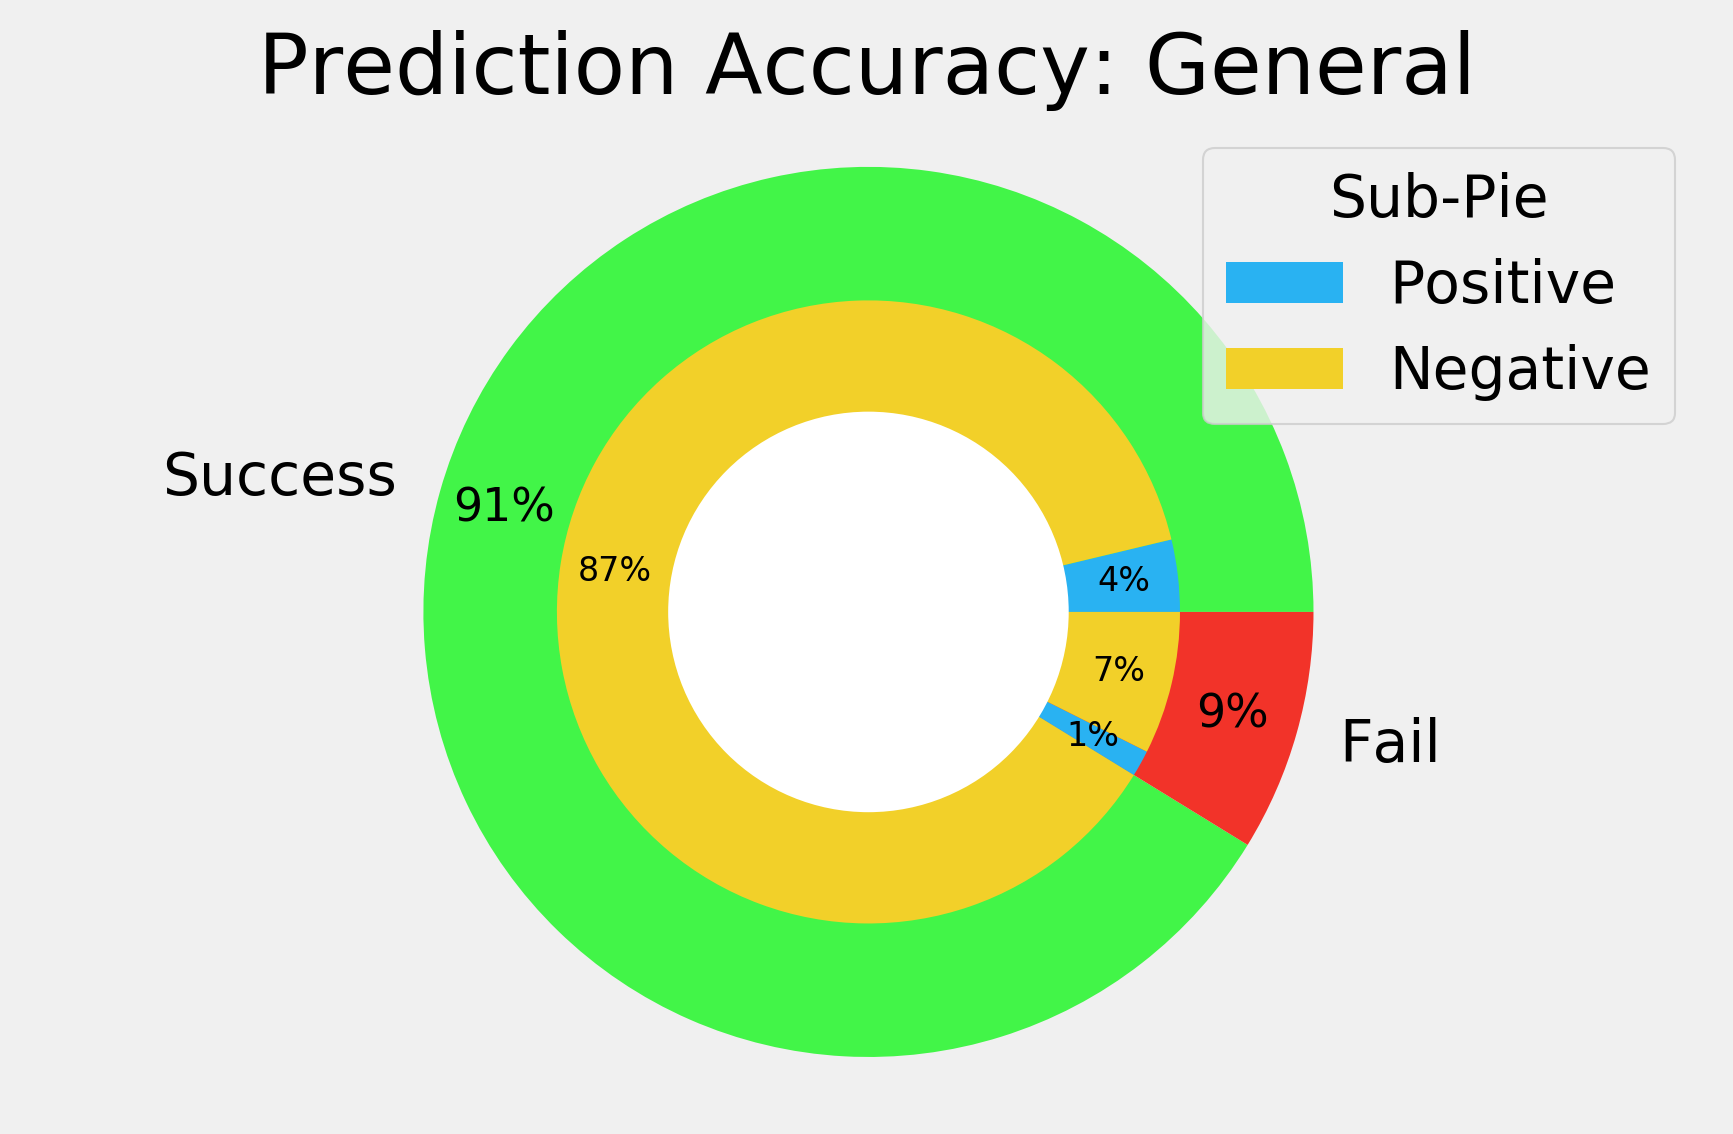

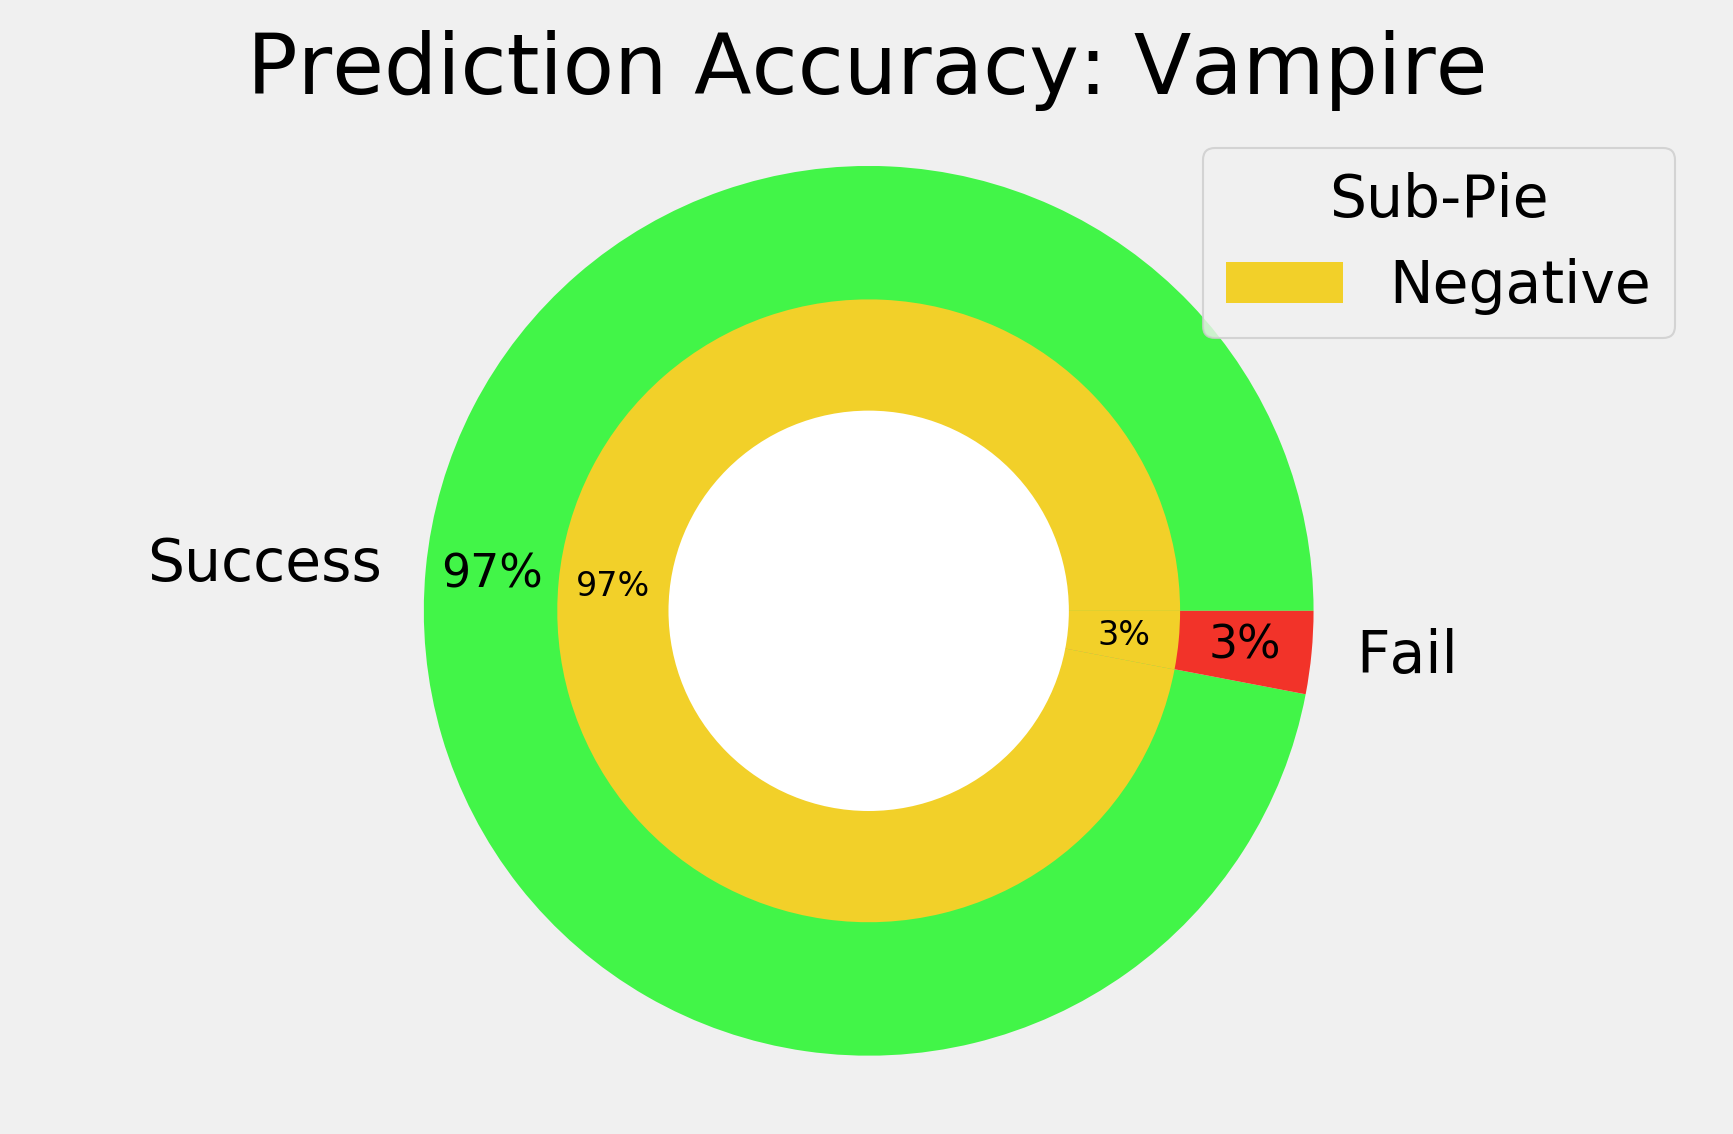

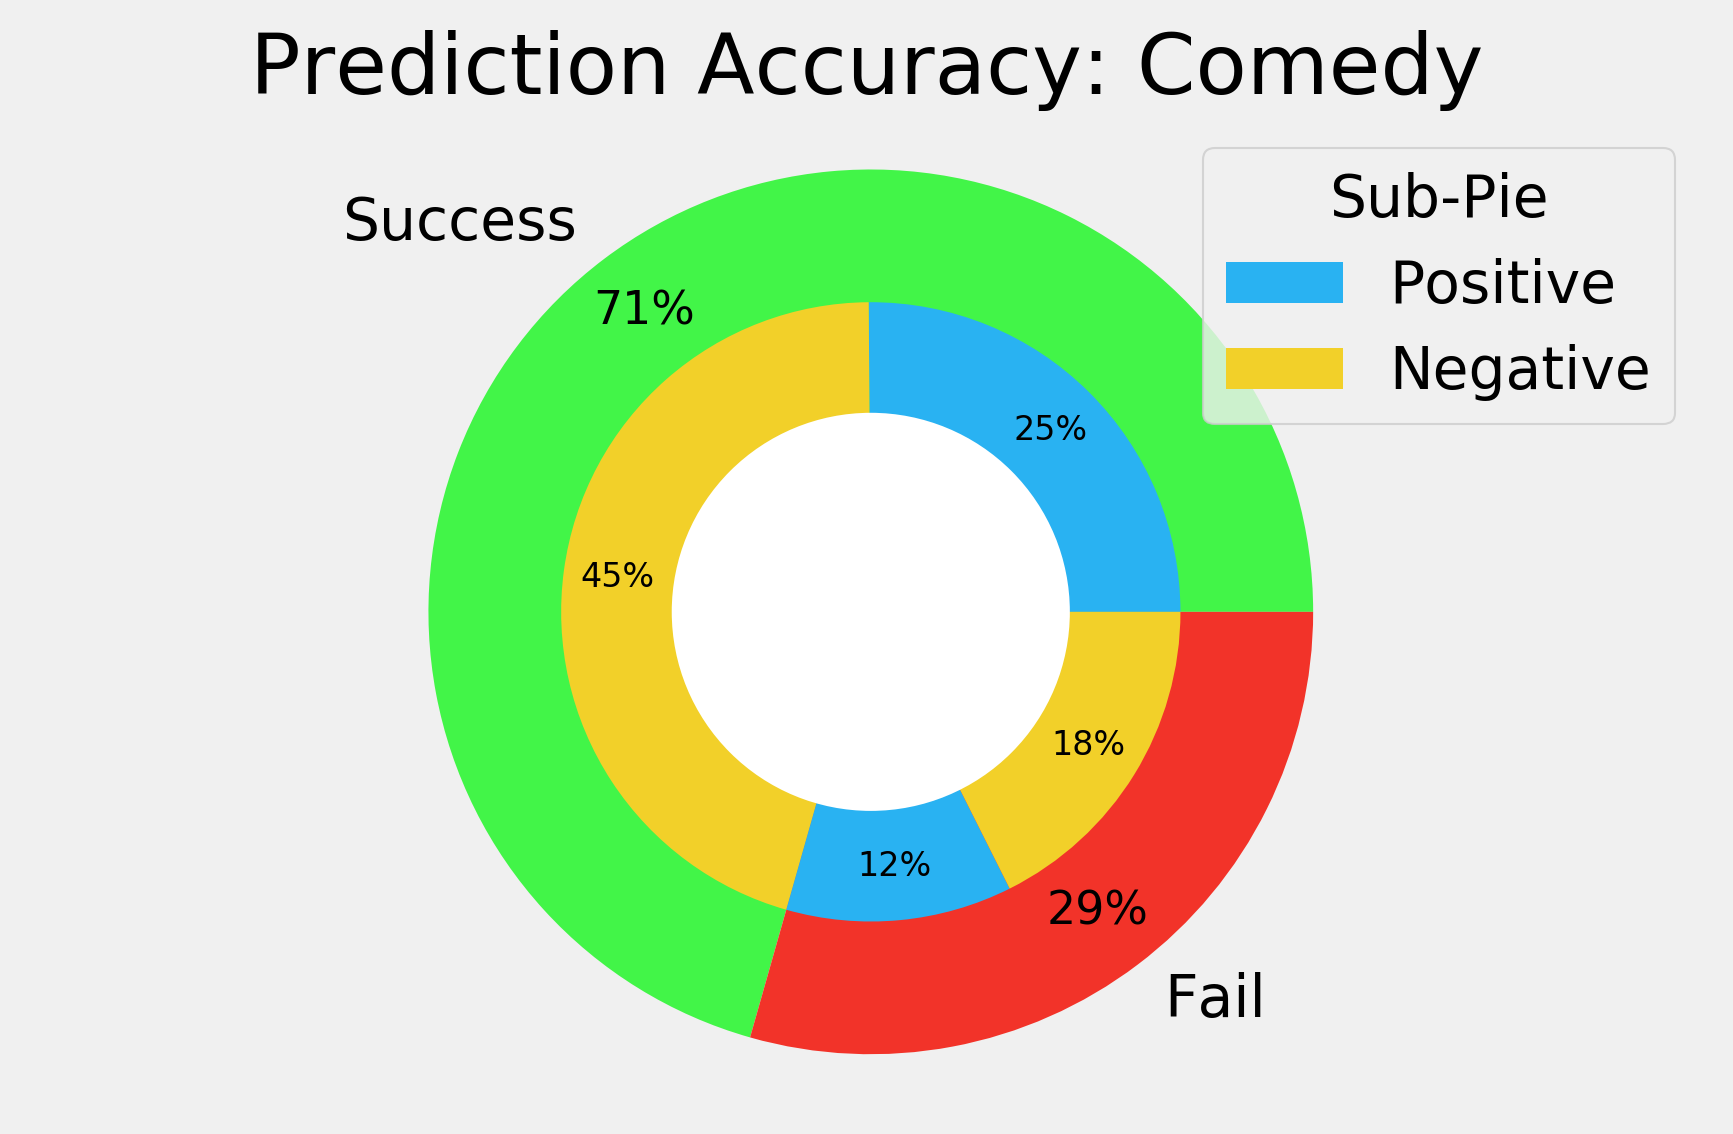

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI
style.use("fivethirtyeight")

# Returns true if a word is in any of the strings in a list of strings
def word_in_list(word, list_of_strings):
    # we create an array of boolean values defined by wether or not the word is in each string
    # if we have at least one True in this list, it means that we found it at least once
    return True if True in [word in e for e in list_of_strings] else False

# Draw a nested pie chart describing the components of an accuracy.
# line_as_series = line of the accuracy df. Could be a generated line (mean line)
def accuracy_pie(line_as_series):    
    color_h = {"green": "#42f548", "red": "#f23329", "cyan": "#29b2f2", "yellow": "#f2d029"}
    
    # Main pie data: Success proportion vs Fail proportion
    labels = ["Success", "Fail"]
    sizes = [line_as_series.accuracy, 100 - line_as_series.accuracy]
    colors = [color_h["green"], color_h["red"]]
    
    # Sub-pie data: True Positive proportion, True Negative proportion, False Positive Proportion, False Negative proportion
    sub_labels = ["True Positive", "True Negative", "False Positive", "False Negative"]
    sub_sizes = [line_as_series.true_positive, line_as_series.true_negative,
                    line_as_series.false_positive, line_as_series.false_negative]
    sub_colors = [color_h["cyan"], color_h["yellow"], color_h["cyan"], color_h["yellow"]]
    # Among the 4 items, we only display those which will display as at least .5%, otherwise it displays a useless 0%
    labels_subpie = []
    sizes_subpie = []
    colors_subpie = []
    item_data = {}
    for i in range(4):
        if sub_sizes[i] > 0.49:
            labels_subpie.append(sub_labels[i])
            sizes_subpie.append(sub_sizes[i])
            colors_subpie.append(sub_colors[i])
      
    # Title
    # If the name attribute is empty, it means that the plot is on general accuracy. Otherwise it's on a particual genre
    accuracy_type = line_as_series.name if line_as_series.name != None else "General" 
    title = "Prediction Accuracy: " + accuracy_type
    
    # Plot
    wedges, labels, autopct = plt.pie(sizes, labels=labels, colors=colors, startangle=0,frame=True,    # outer plot
                                      autopct='%1.0f%%', pctdistance=0.85)
    plt.setp(autopct, fontsize=11)
    
    wedges, labels, autopct = plt.pie(sizes_subpie, colors=colors_subpie,radius=0.7,startangle=0,    # innter plot
                                      autopct='%1.0f%%', pctdistance=0.825, labeldistance = .4)
    plt.setp(labels, fontsize=6)
    plt.setp(autopct, fontsize=8)
    
    # Adding legend for the subpie [Positive [color] Negative [color]]
    # We only keep the legends for which we have a representation in the plot
    subpie_legend_labels = [word for word in ["Positive", "Negative"] if word_in_list(word, labels_subpie)]
    plt.legend(wedges[:len(subpie_legend_labels)], subpie_legend_labels, title = "Sub-Pie")
    
    # Drawing a circle in the middle
    centre_circle = plt.Circle((0,0),0.45,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()    
    
accuracy_pie(accuracy_df.mean())     # General Accuracy
accuracy_pie(accuracy_df.iloc[0])    # Best Accuracy
accuracy_pie(accuracy_df.iloc[-1])   # Worst Accuracy

False

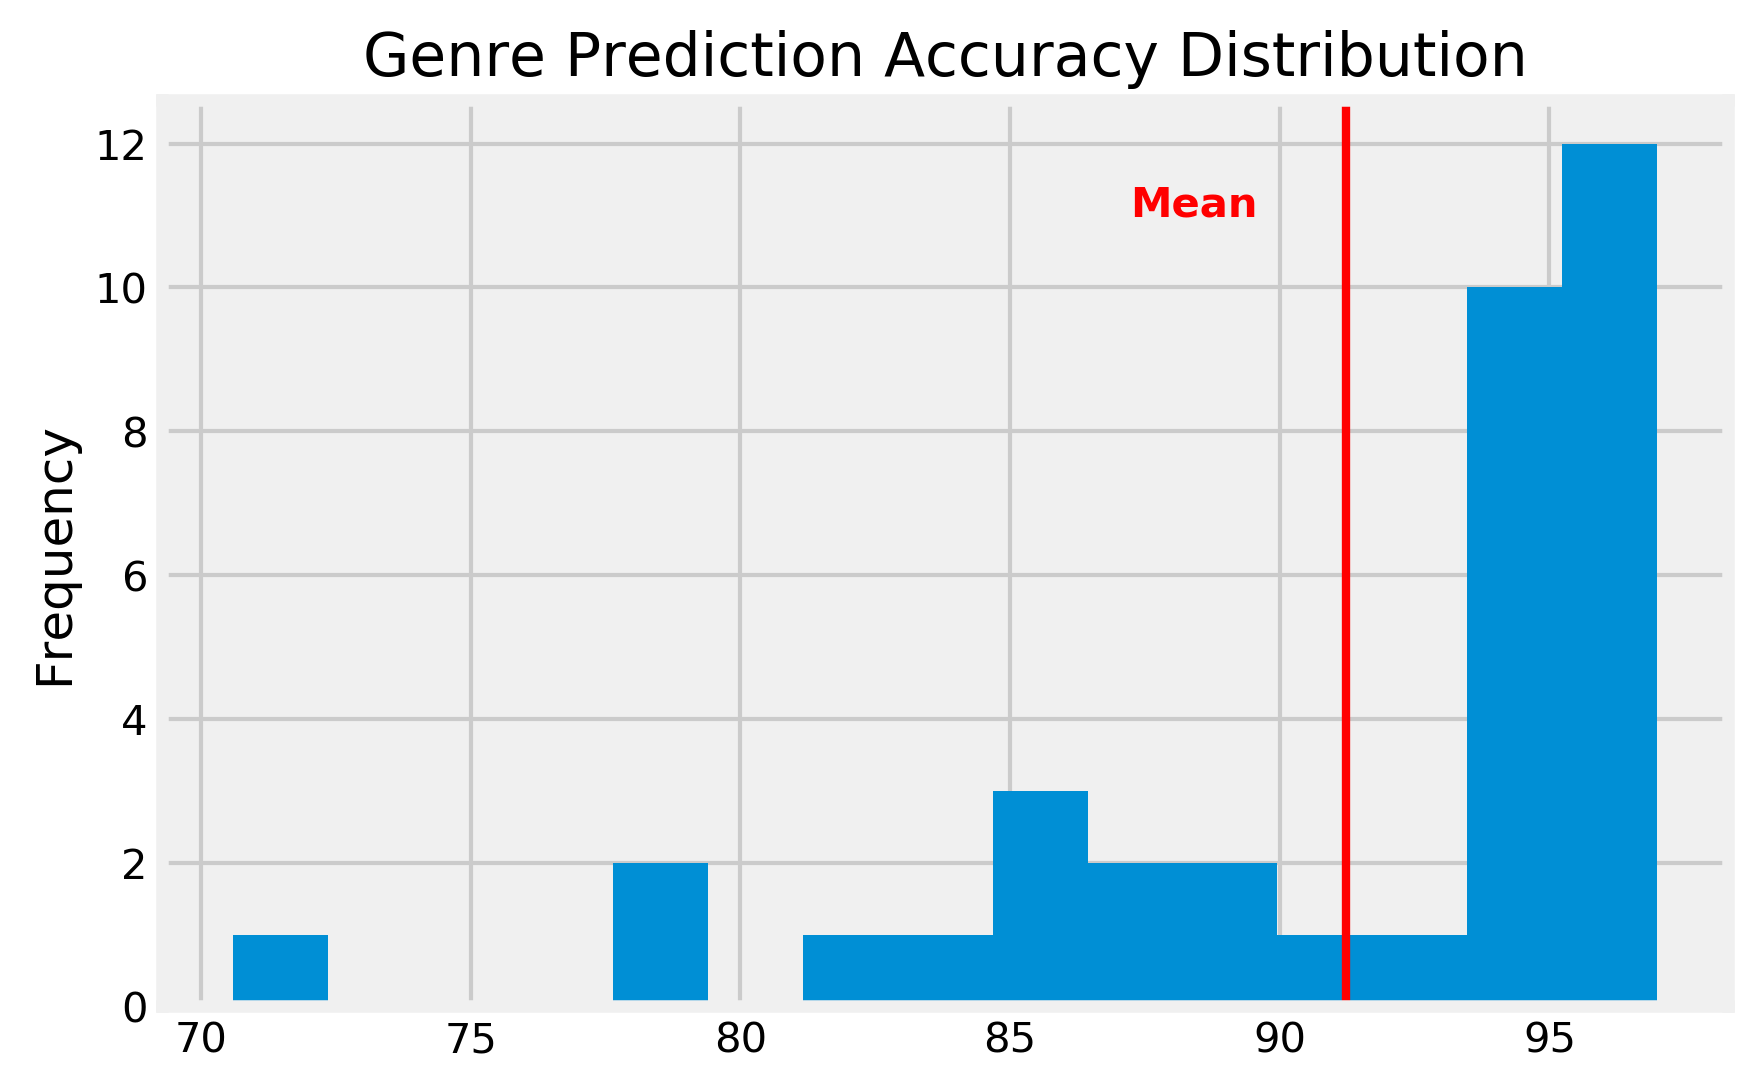

In [21]:
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI

graph = accuracy_df["accuracy"].plot.hist(title = "Genre Prediction Accuracy Distribution", bins = 15)
mean = accuracy_df["accuracy"].mean()
graph.axvline(mean, color= "red", linewidth=2);    # ';' prevents this line from displaying smth
graph.text(x = mean - 4, y = 11, s = "Mean", weight = 'bold', color = "red");

## What makes an anime easy to predict its genres? Looking for correlations

In [22]:
corr_df = pd.concat([accuracy_df["accuracy"], pd.Series(genre_p, name = "percentage of total") * 100], axis = 1, sort=False)
corr_df["avg_words_per_synopsis"] = corr_df.apply(lambda row: genre_n_words[row.name] / training_set_clean[row.name].sum(), axis = 1)

# removing nsfw genres in necessary
if not Constants.INCLUDE_NSFW_GENRES:
    corr_df = corr_df[:-(len(genres) - len(genres_sfw))]
    
corr_df
corr_df.corr()
    
# The correlation between the accuracy of the predictions of the presence/absence of a genre
#and the proportion of animes of this genre is almost perfectly negative
# The more common the genre, the harder it is to predict

,accuracy,percentage of total,avg_words_per_synopsis
Vampire,96.995708,4.557641,34.576471
Cars,96.781116,4.504021,19.511905
Space,96.566524,4.289544,48.450000
Kids,96.137339,5.522788,35.271845
Demons,96.137339,5.254692,39.500000
Josei,95.922747,4.075067,30.605263
Martial Arts,95.922747,5.040214,36.510638
Parody,95.708155,5.308311,34.858586
Police,95.708155,4.664879,39.701149
Dementia,95.708155,4.289544,21.437500


,accuracy,percentage of total,avg_words_per_synopsis
accuracy,1.000000,-0.971383,-0.346985
percentage of total,-0.971383,1.000000,0.337123
avg_words_per_synopsis,-0.346985,0.337123,1.000000


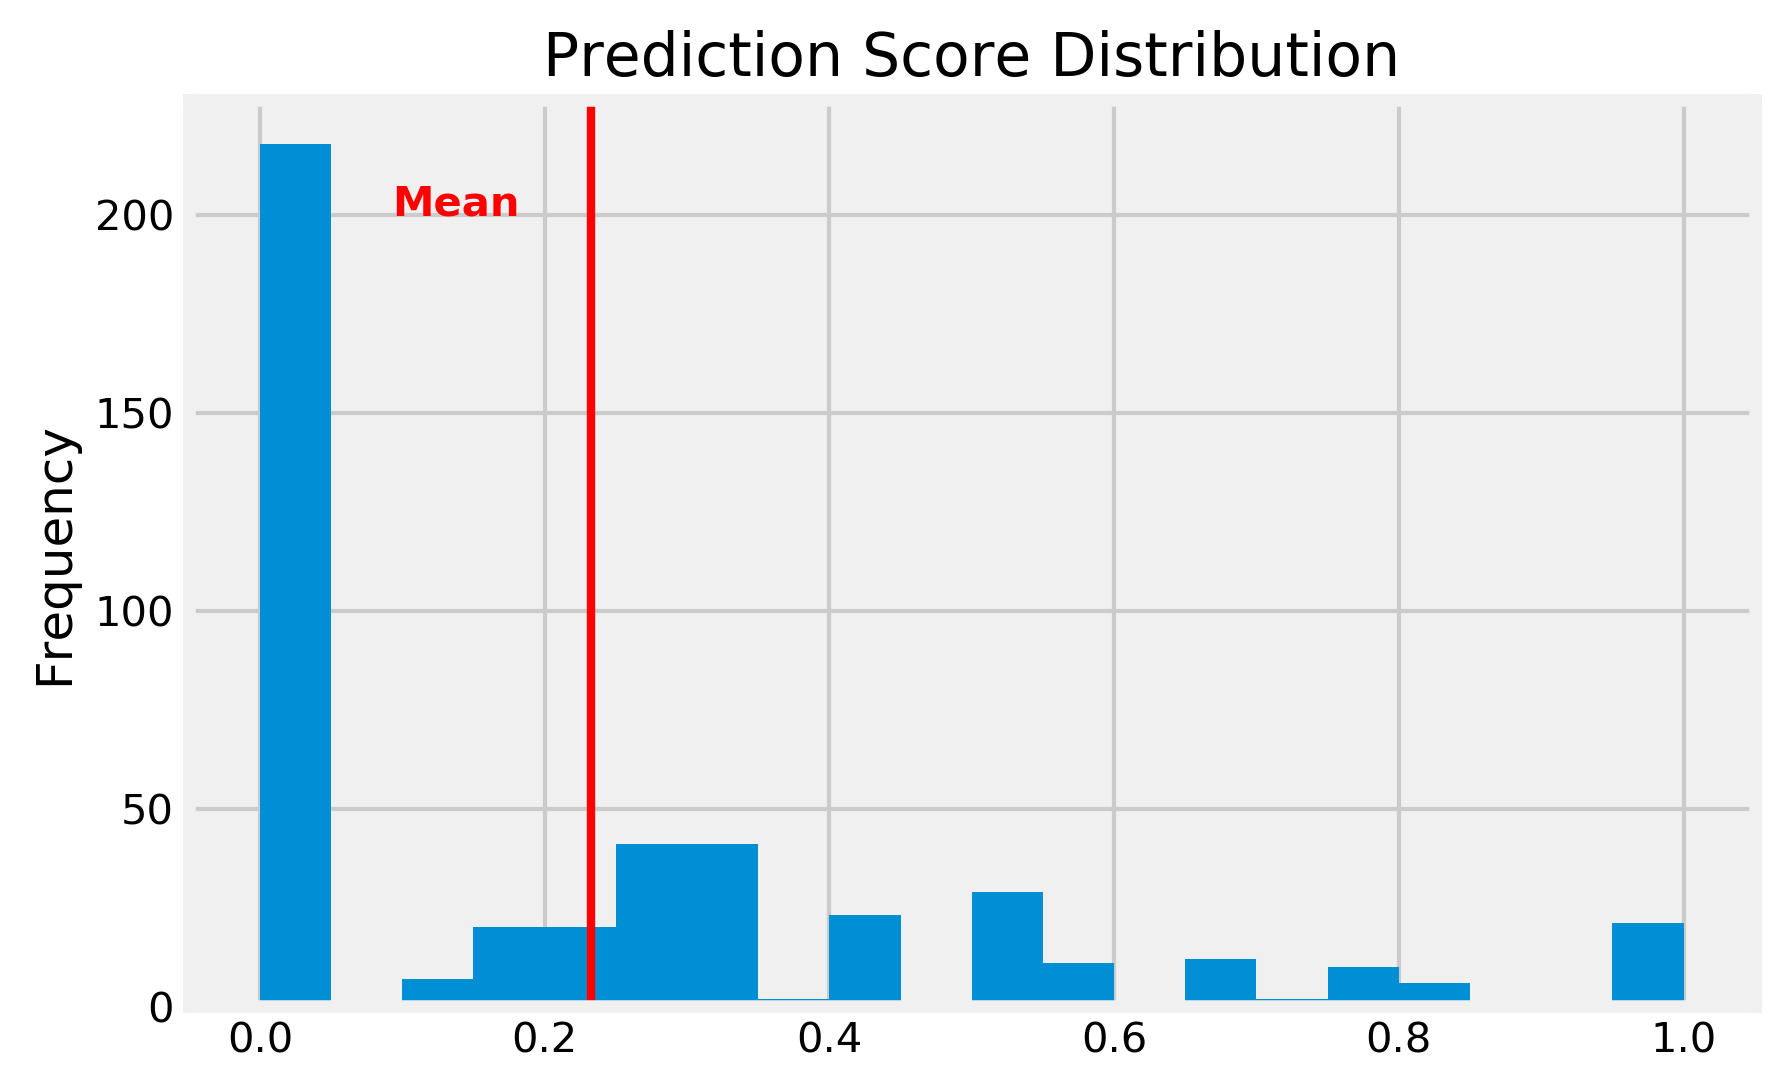

In [25]:
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI

graph = isolated_test_set["prediction_score"].plot.hist(title = "Prediction Score Distribution", bins = 20)
mean = isolated_test_set["prediction_score"].mean()
graph.axvline(mean, color= "red", linewidth=2);    # ';' prevents this line from displaying smth
graph.text(x = mean - .14, y = 200, s = "Mean", weight = 'bold', color = "red");

In [26]:
isolated_test_set[isolated_test_set["prediction_score"] < .1].sort_values("prediction_score", ascending=False)[["title", "genres", "predicted_genres", "prediction_score", "predicted_perfectly"]]

,title,genres,predicted_genres,prediction_score,predicted_perfectly
1,"Sora no Iro, Mizu no Iro",[Hentai],[],0.0,False
308,Toki wo Kakeru Shoujo,"[Adventure, Drama, Romance, Sci-Fi]",[Comedy],0.0,False
285,Oniisama e...,"[Psychological, Drama, School, Shoujo, Shoujo Ai]","[School, Comedy]",0.0,False
288,No Game No Life,"[Game, Adventure, Comedy, Supernatural, Ecchi,...",[],0.0,False
291,Samurai Deeper Kyou,"[Adventure, Comedy, Historical, Supernatural, ...","[Action, Fantasy, Adventure]",0.0,False
...,...,...,...,...,...
178,Yowamushi Pedal,"[Comedy, Sports, Drama, Shounen]",[],0.0,False
181,Hakuouki: Otogisoushi Special,"[Historical, Samurai, Fantasy, Josei]",[Comedy],0.0,False
182,Higashi no Eden,"[Action, Sci-Fi, Mystery, Drama, Romance, Thri...",[],0.0,False
185,Hiyokoi,"[Romance, School, Shoujo]",[Comedy],0.0,False


In [27]:
# Checking correlation between [avg number of words in synopsis of this genre] and [accuracy] 

avg_words_per_synopsis = genre_p
accuracy_with_wordcount = pd.concat([accuracy_df["accuracy"], pd.Series(genre_n_words, name = "avg_words_per_synopsis")], axis = 1, sort=False)
accuracy_with_wordcount["avg_words_per_synopsis"] = accuracy_with_wordcount.apply(lambda row: row.avg_words_per_synopsis / training_set_clean[row.name].sum(), axis = 1)
# removing nsfw genres in necessary
if not Constants.INCLUDE_NSFW_GENRES:
    accuracy_with_wordcount = accuracy_with_wordcount[:-(len(genres) - len(genres_sfw))]
accuracy_with_wordcount
accuracy_with_wordcount.corr()
# Weak negative conclusion, nothing conclusive
# This is probably due to the fact that animes have many genres at once, so this metric is not that useful

,accuracy,avg_words_per_synopsis
Vampire,96.995708,34.576471
Cars,96.781116,19.511905
Space,96.566524,48.450000
Kids,96.137339,35.271845
Demons,96.137339,39.500000
Josei,95.922747,30.605263
Martial Arts,95.922747,36.510638
Parody,95.708155,34.858586
Police,95.708155,39.701149
Dementia,95.708155,21.437500


,accuracy,avg_words_per_synopsis
accuracy,1.000000,-0.346985
avg_words_per_synopsis,-0.346985,1.000000


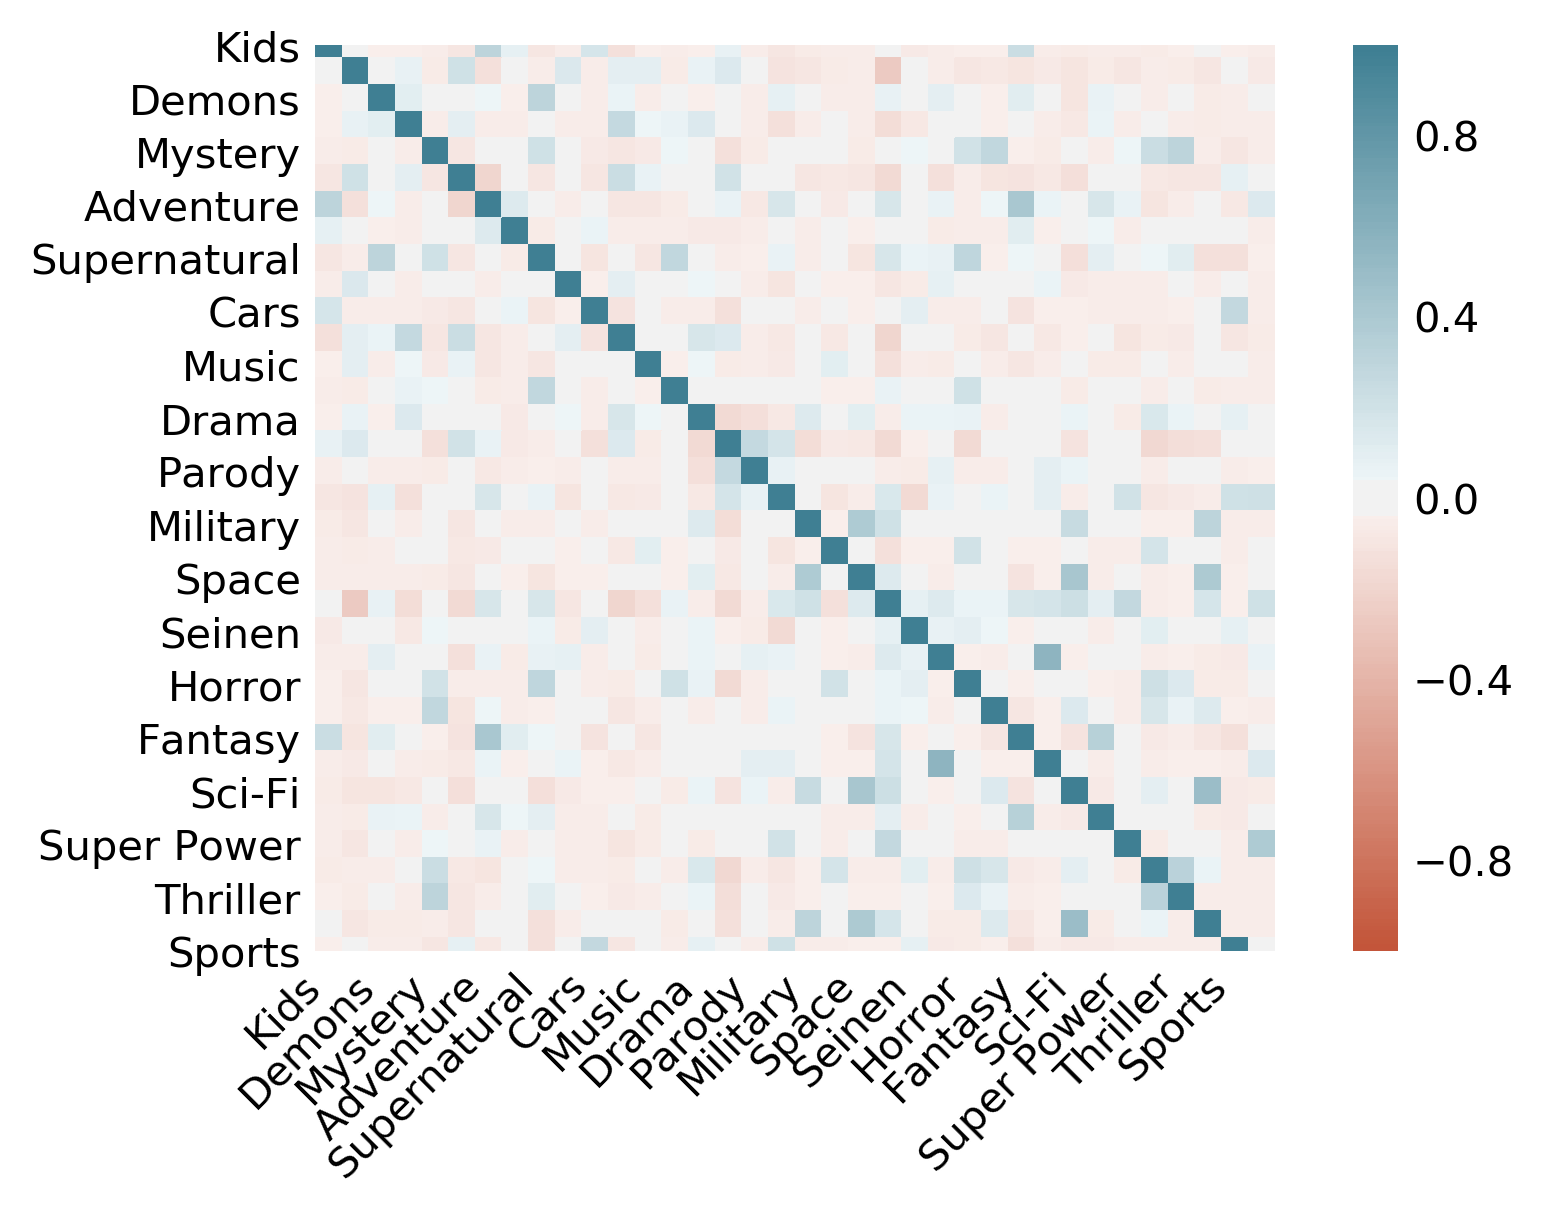

In [28]:
import seaborn as sns

def corr_heatmap(corr_data):
    ax = sns.heatmap(
        corr_data, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# we select the genre columns from our training set, and compute correlations
corr = training_set_clean[selected_genres].corr()
corr_heatmap(corr)

In [29]:
# Isolates the genres for which we have a significant correlation (> .5 or < -.5)
def select_significant_corrs(df):
    df = df.copy()
    
    # Sets correlations to 0 if they are not statistically significant
    for genre in selected_genres:
        df[genre] = df[genre].apply(lambda c: 0 if -.5 < c < .5 else c)
    
    # Selects only genres that have at least one significant correlation with another genre
    relevant_genres = [genre for genre in selected_genres if df.loc[genre].sum() > 1]    # 1 bc we also have the correlation with itself

    return df.loc[relevant_genres][relevant_genres]

significant_correlations = select_significant_corrs(corr)
significant_correlations
# corr_heatmap(significant_correlations)    # don't have enough significant correlations to make visualizing useful



,Historical,Samurai
Historical,1.000000,0.559411
Samurai,0.559411,1.000000


Out of all the combinations of genres, only one has a significant correlation, which is suprising.
The combination Samurai + Historical makes a lot of sense as we can imagine the strong relationship between these two genres. 

,Kids,Slice of Life,Demons,Shoujo,Harem,Yaoi,Mystery,School,Adventure,Game,Supernatural,Josei,Cars,Romance,Music,Vampire,Drama,Comedy,Parody,Shounen,Military,Dementia,Space,Action,Shounen Ai,Seinen,Historical,Hentai,Horror,Police,Fantasy,Samurai,Sci-Fi,Shoujo Ai,Magic,Super Power,Psychological,Thriller,Ecchi,Mecha,Yuri,Sports,Martial Arts
Kids,1.000000,0.033493,0.010204,0.018182,0.000000,0.000000,0.014851,0.009146,0.199430,0.137931,0.008242,0.000000,0.238095,0.002237,0.018349,0.000000,0.039501,0.075067,0.000000,0.013298,0.000000,0.0000,0.0000,0.052198,0.000000,0.000000,0.013605,0.000000,0.016393,0.011494,0.156962,0.000000,0.023669,0.000000,0.014085,0.008333,0.000000,0.012346,0.000000,0.074324,0.000000,0.018349,0.000000
Slice of Life,0.067961,1.000000,0.071429,0.209091,0.038760,0.057143,0.049505,0.246951,0.031339,0.091954,0.074176,0.328947,0.023810,0.163311,0.238532,0.011765,0.145530,0.166220,0.070707,0.042553,0.000000,0.0125,0.0375,0.008242,0.202899,0.123529,0.047619,0.009259,0.000000,0.000000,0.045570,0.000000,0.041420,0.389831,0.042254,0.000000,0.056738,0.012346,0.031447,0.006757,0.000000,0.128440,0.010638
Demons,0.009709,0.033493,1.000000,0.145455,0.093023,0.000000,0.054455,0.039634,0.071225,0.011494,0.192308,0.026316,0.000000,0.071588,0.000000,0.070588,0.035343,0.060322,0.000000,0.087766,0.065574,0.0000,0.0000,0.074176,0.000000,0.052941,0.129252,0.055556,0.081967,0.011494,0.101266,0.038961,0.002959,0.000000,0.105634,0.025000,0.014184,0.024691,0.075472,0.000000,0.029412,0.000000,0.063830
Shoujo,0.019417,0.110048,0.163265,1.000000,0.108527,0.000000,0.024752,0.103659,0.034188,0.000000,0.060440,0.000000,0.000000,0.167785,0.100917,0.129412,0.112266,0.067024,0.000000,0.000000,0.016393,0.0250,0.0000,0.015110,0.173913,0.000000,0.047619,0.000000,0.032787,0.011494,0.065823,0.000000,0.017751,0.101695,0.105634,0.016667,0.035461,0.000000,0.000000,0.006757,0.000000,0.009174,0.010638
Harem,0.000000,0.023923,0.122449,0.127273,1.000000,0.000000,0.019802,0.219512,0.019943,0.000000,0.071429,0.026316,0.000000,0.205817,0.073394,0.117647,0.022869,0.121984,0.111111,0.071809,0.016393,0.0000,0.0250,0.059066,0.014493,0.029412,0.006803,0.064815,0.000000,0.022989,0.070886,0.038961,0.062130,0.000000,0.077465,0.033333,0.021277,0.000000,0.415094,0.067568,0.029412,0.009174,0.074468
Yaoi,0.000000,0.009569,0.000000,0.000000,0.000000,1.000000,0.000000,0.009146,0.000000,0.000000,0.005495,0.000000,0.000000,0.038031,0.027523,0.000000,0.039501,0.013405,0.000000,0.000000,0.008197,0.0000,0.0000,0.004121,0.014493,0.000000,0.013605,0.083333,0.008197,0.000000,0.000000,0.025974,0.008876,0.000000,0.000000,0.000000,0.007092,0.000000,0.000000,0.006757,0.000000,0.018349,0.000000
Mystery,0.029126,0.047847,0.112245,0.045455,0.031008,0.000000,1.000000,0.048780,0.094017,0.091954,0.239011,0.092105,0.000000,0.060403,0.018349,0.164706,0.118503,0.061662,0.020202,0.119681,0.073770,0.1125,0.0125,0.107143,0.043478,0.152941,0.136054,0.000000,0.336066,0.505747,0.083544,0.012987,0.106509,0.016949,0.049296,0.158333,0.368794,0.555556,0.018868,0.054054,0.000000,0.000000,0.042553
School,0.029126,0.387560,0.132653,0.309091,0.558140,0.085714,0.079208,1.000000,0.025641,0.172414,0.107143,0.105263,0.011905,0.335570,0.275229,0.141176,0.174636,0.265416,0.181818,0.196809,0.040984,0.0250,0.0000,0.094780,0.173913,0.152941,0.020408,0.074074,0.090164,0.000000,0.091139,0.025974,0.065089,0.508475,0.133803,0.150000,0.063830,0.012346,0.427673,0.060811,0.147059,0.302752,0.127660
Adventure,0.679612,0.052632,0.255102,0.109091,0.054264,0.000000,0.163366,0.027439,1.000000,0.413793,0.170330,0.092105,0.214286,0.118568,0.045872,0.070588,0.166320,0.219839,0.050505,0.311170,0.172131,0.0500,0.2000,0.269231,0.072464,0.147059,0.272109,0.000000,0.106557,0.264368,0.498734,0.285714,0.186391,0.016949,0.401408,0.291667,0.042553,0.074074,0.075472,0.195946,0.000000,0.064220,0.414894
Game,0.116505,0.038278,0.010204,0.000000,0.000000,0.000000,0.039604,0.045732,0.102564,1.000000,0.019231,0.026316,0.095238,0.026846,0.000000,0.0

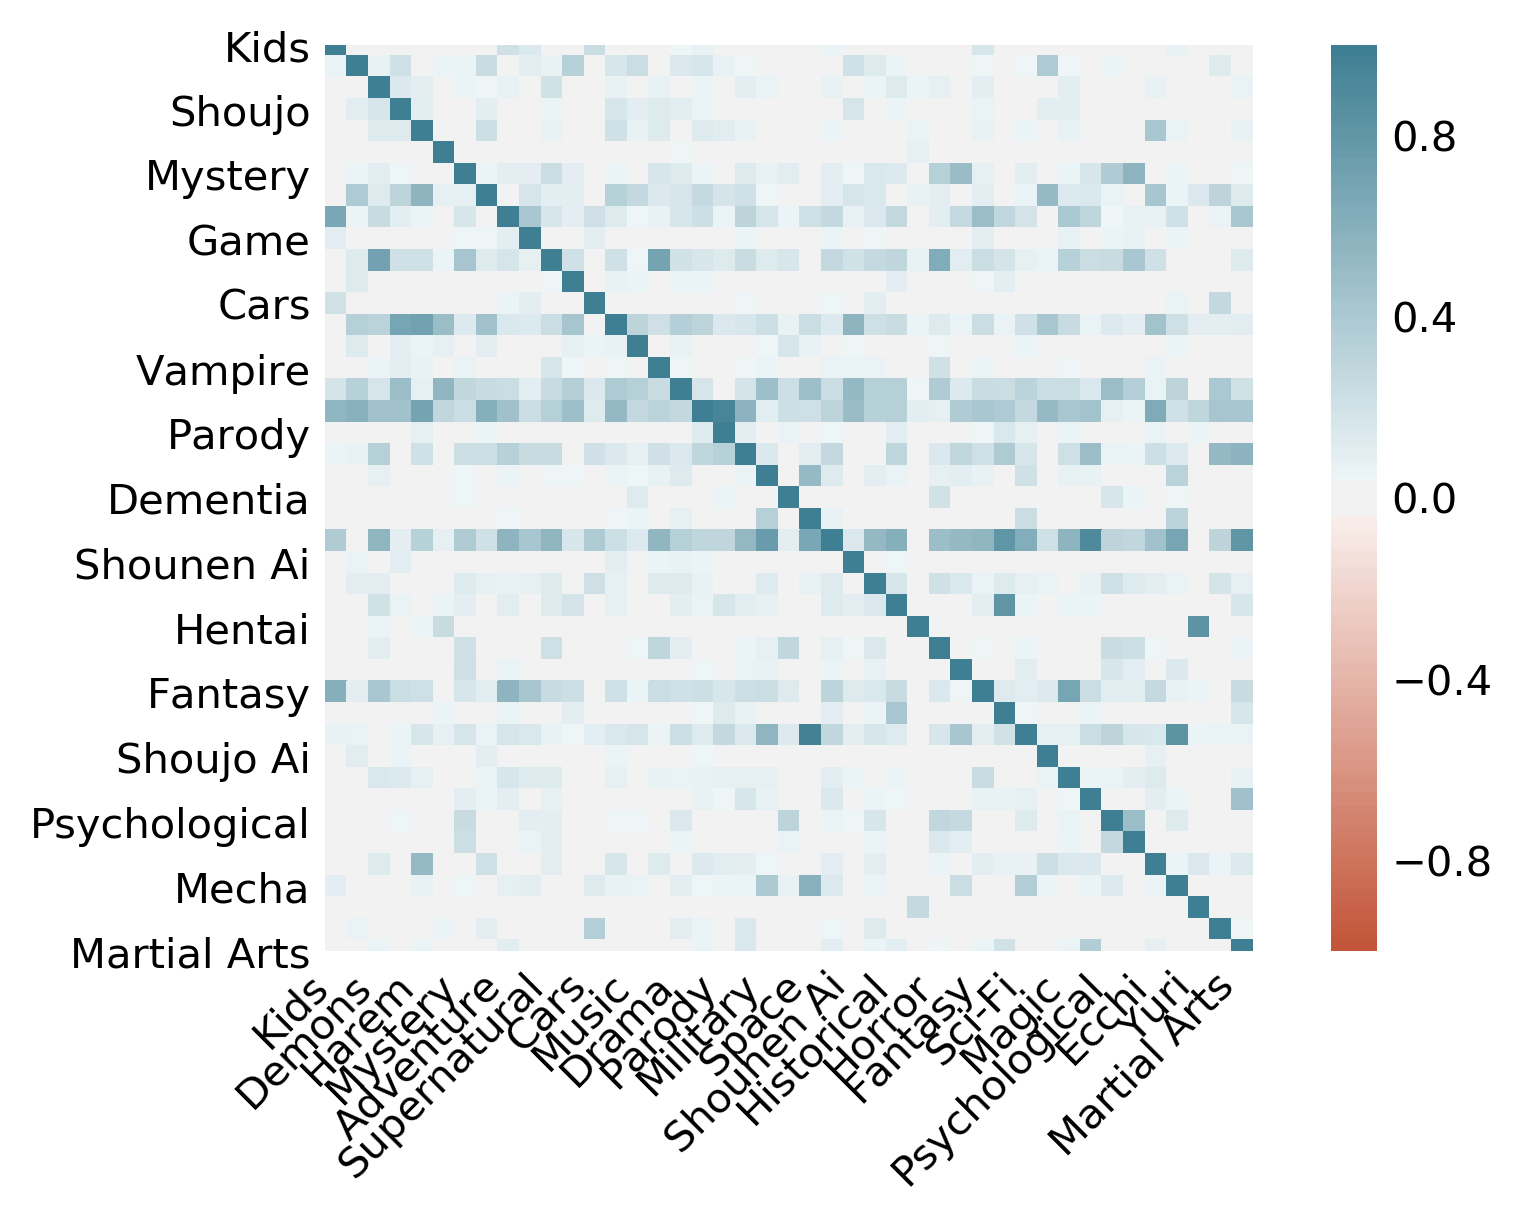

In [30]:
# corr_dict = {g: [{genre: 0} for genre in genres] for g in genres}
corr_dict = {g: [0] * len(genres) for g in genres}
for g in genres:
    for i, g2 in enumerate(genres):
        corr_dict[g][i] = ((training_set_clean[g]) & (training_set_clean[g2])).sum() / training_set_clean[g].sum()
# corr_dict
genre_relationships = pd.DataFrame(corr_dict)       
genre_relationships.index = genres
genre_relationships
corr_heatmap(genre_relationships)

## Visualizing the distribution of genres

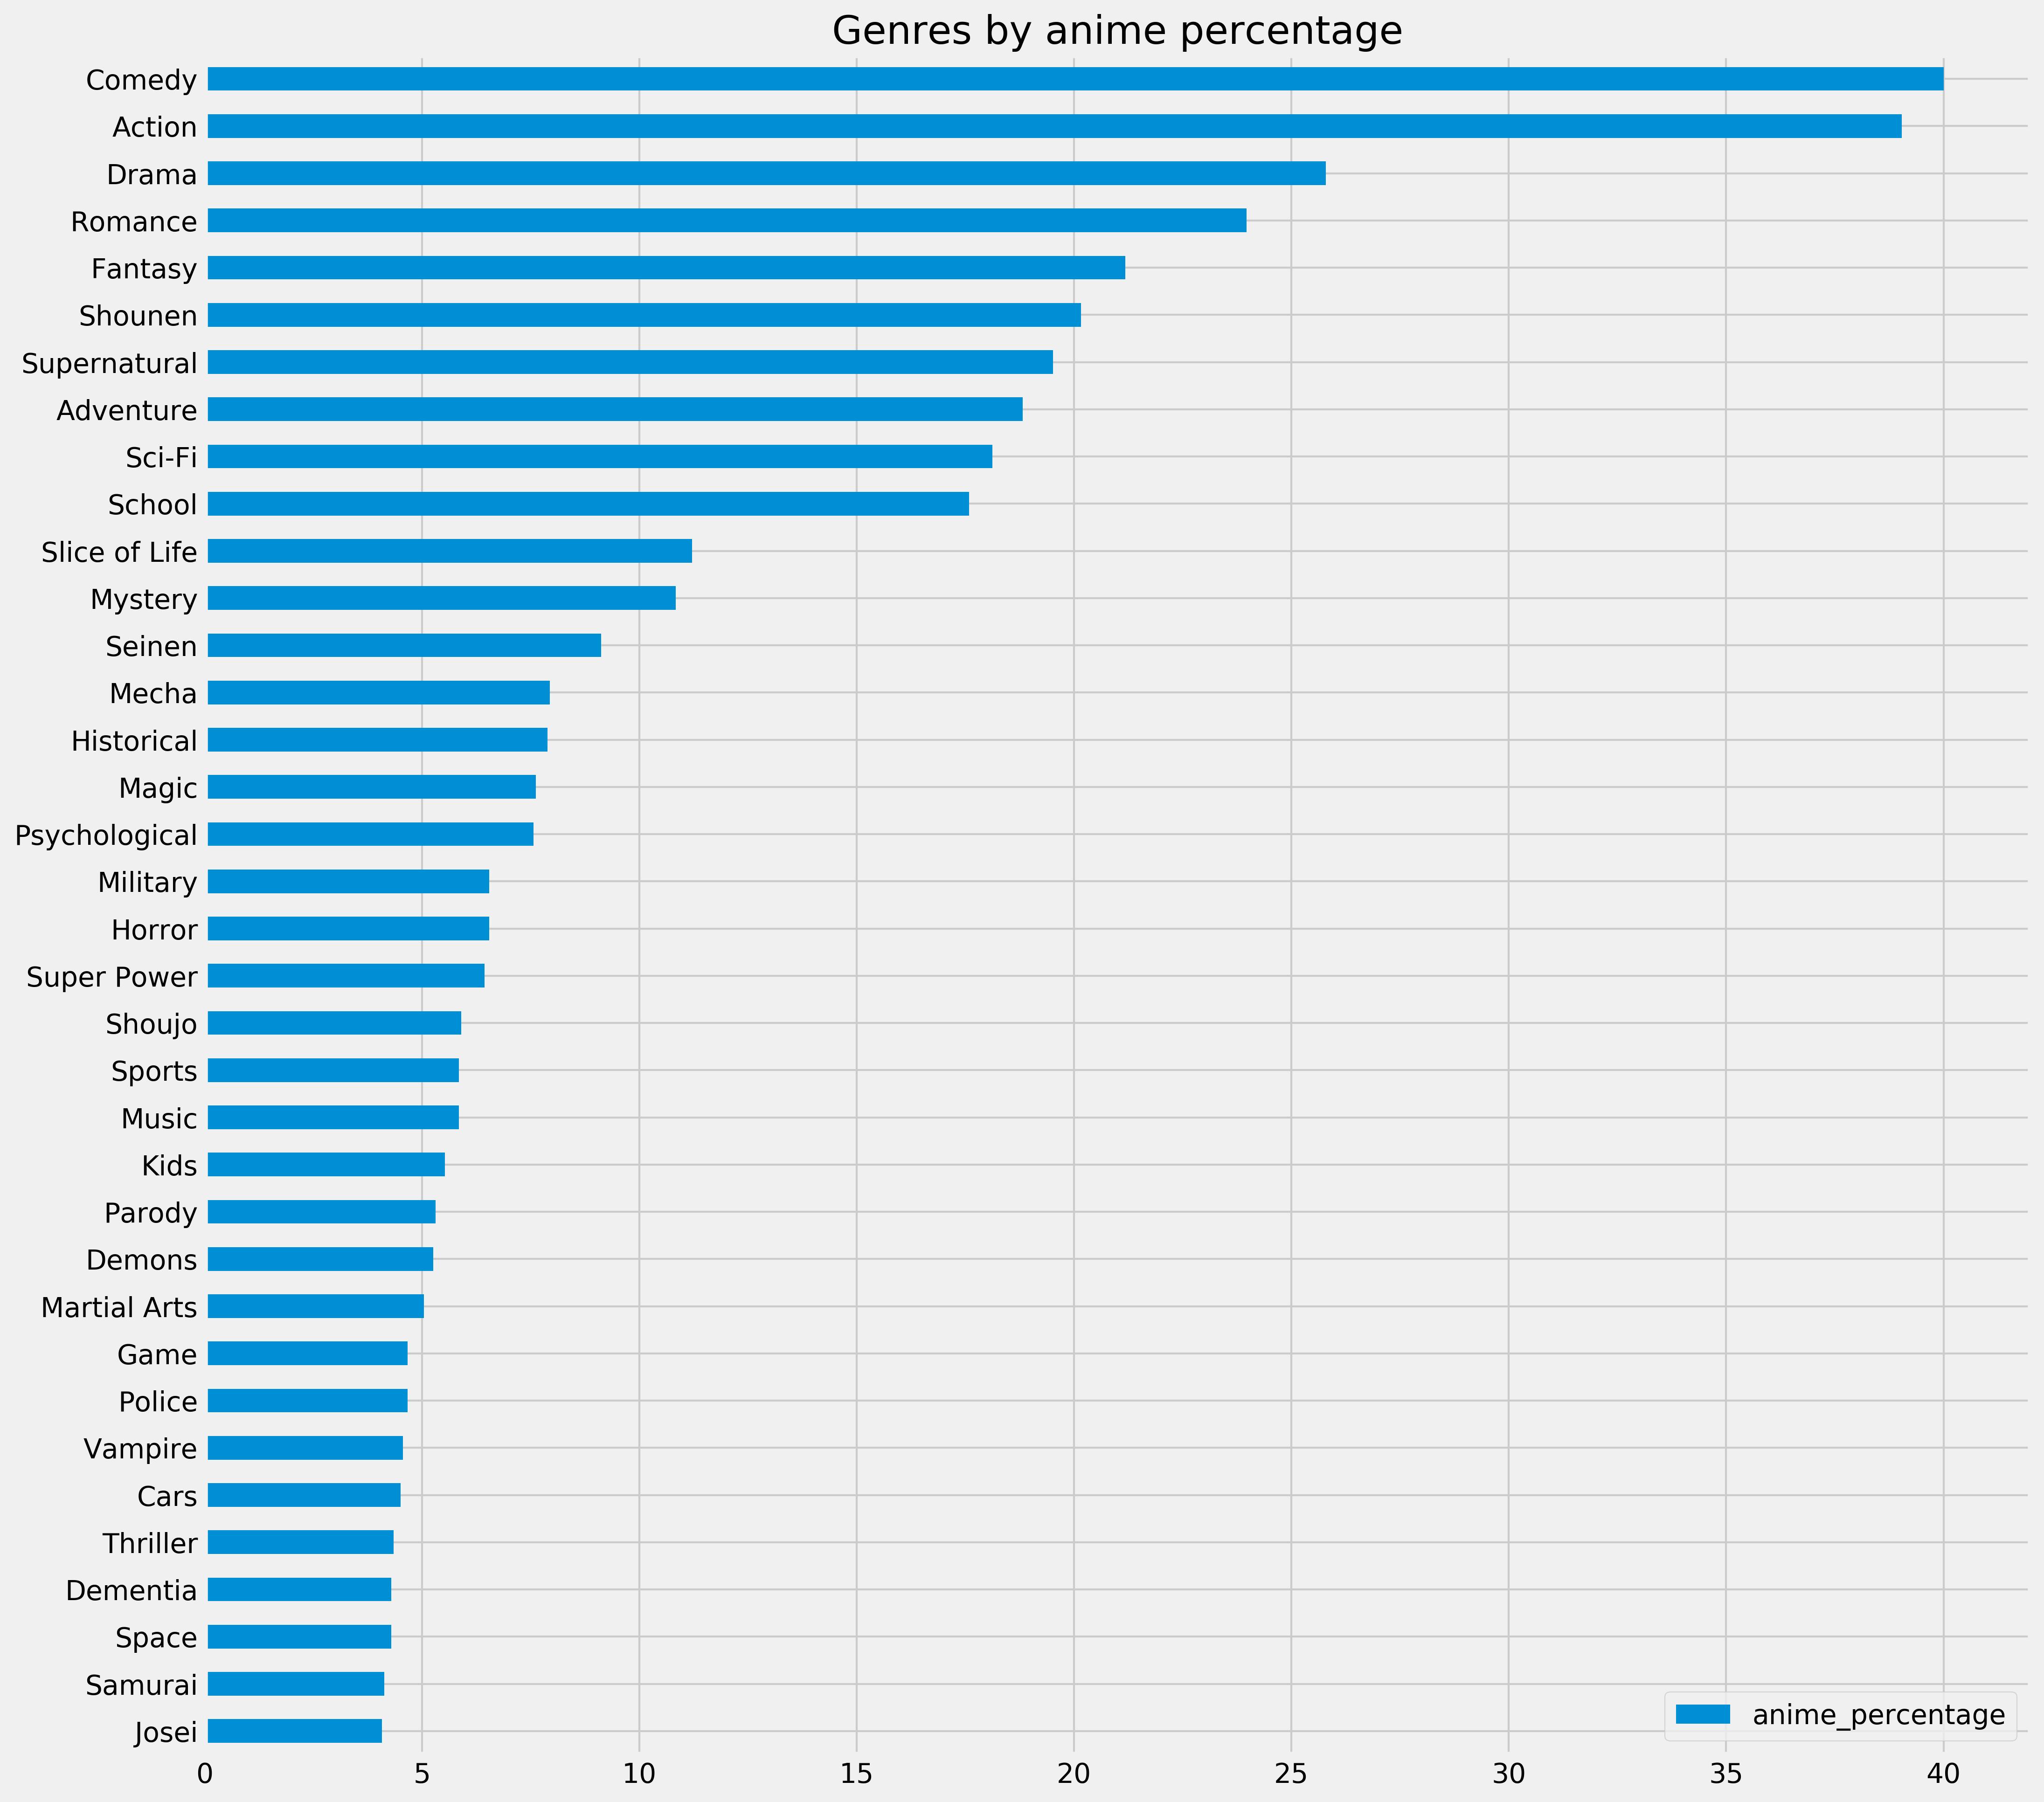

In [230]:
genre_distribution = pd.Series(genre_p, name = "anime_percentage") * 100
genre_distribution.loc[selected_genres].sort_values().plot.barh(figsize=(15, 15), title="Genres by anime percentage", legend=True)

## Visualizing the most significant words per genre
It could be interesting to see which words weigh the most when deciding if an anime is of a given genre or not.

We will measure the weight of a word as being its lift. The lift of a word measures by how much the probability of being of a genre increases or decreases (factor) when the word is added to the synopsis.

Some words can get a high lift because they are repeated several times in a single synopsis. It is often the case with the name of the main characters of an anime. These words are not significant as they are not inherently linked to a genre.
To exclude these words, we will only keep words that are present in at least 1% of all animes of the given genre.

In [ ]:
# In order to exclude words that have a high lift because of mutliple occurences in a single synopsis,
#we start by computing the amount of animes that feature at least once each word
def get_word_occurences_singleton():
    output_df = pd.DataFrame(columns = [])
    for w in vocabulary:
        output_df[w] = training_set_clean[w].apply(lambda n: False if n == 0 else True)
    return output_df.sum().rename("occurences_singleton")

def plot_best_words_of_genre(g):
    # Creating of a DataFrame allowing us to compute the lift of words
    genre_words = pd.Series(parameters[g], name = "p_word_given_" + g)
    not_genre_words = pd.Series(parameters_no[g], name = "p_word_given_not_" + g)
    genre_words_df = pd.concat([genre_words, not_genre_words, word_occurences_singleton], axis = 1, sort = False)
    genre_words_df["lift"] = (genre_words_df["p_word_given_" + g] - genre_words_df["p_word_given_not_" + g]) / genre_words_df["p_word_given_not_" + g]
    
    # Excluding words that appear in less than 1% of animes of this genre
    min_occurences = training_set_clean[g].sum() * .01
    common_words = genre_words_df[genre_words_df["occurences_singleton"] >= min_occurences]
    
    # Horizontal bar plot of the 15 words with the highest lift
    common_words.sort_values(by = "lift", ascending = False).head(15).sort_values("lift")[["lift"]].plot.barh(title = "Most significant " + g + " words")

word_occurences_singleton = get_word_occurences_singleton()

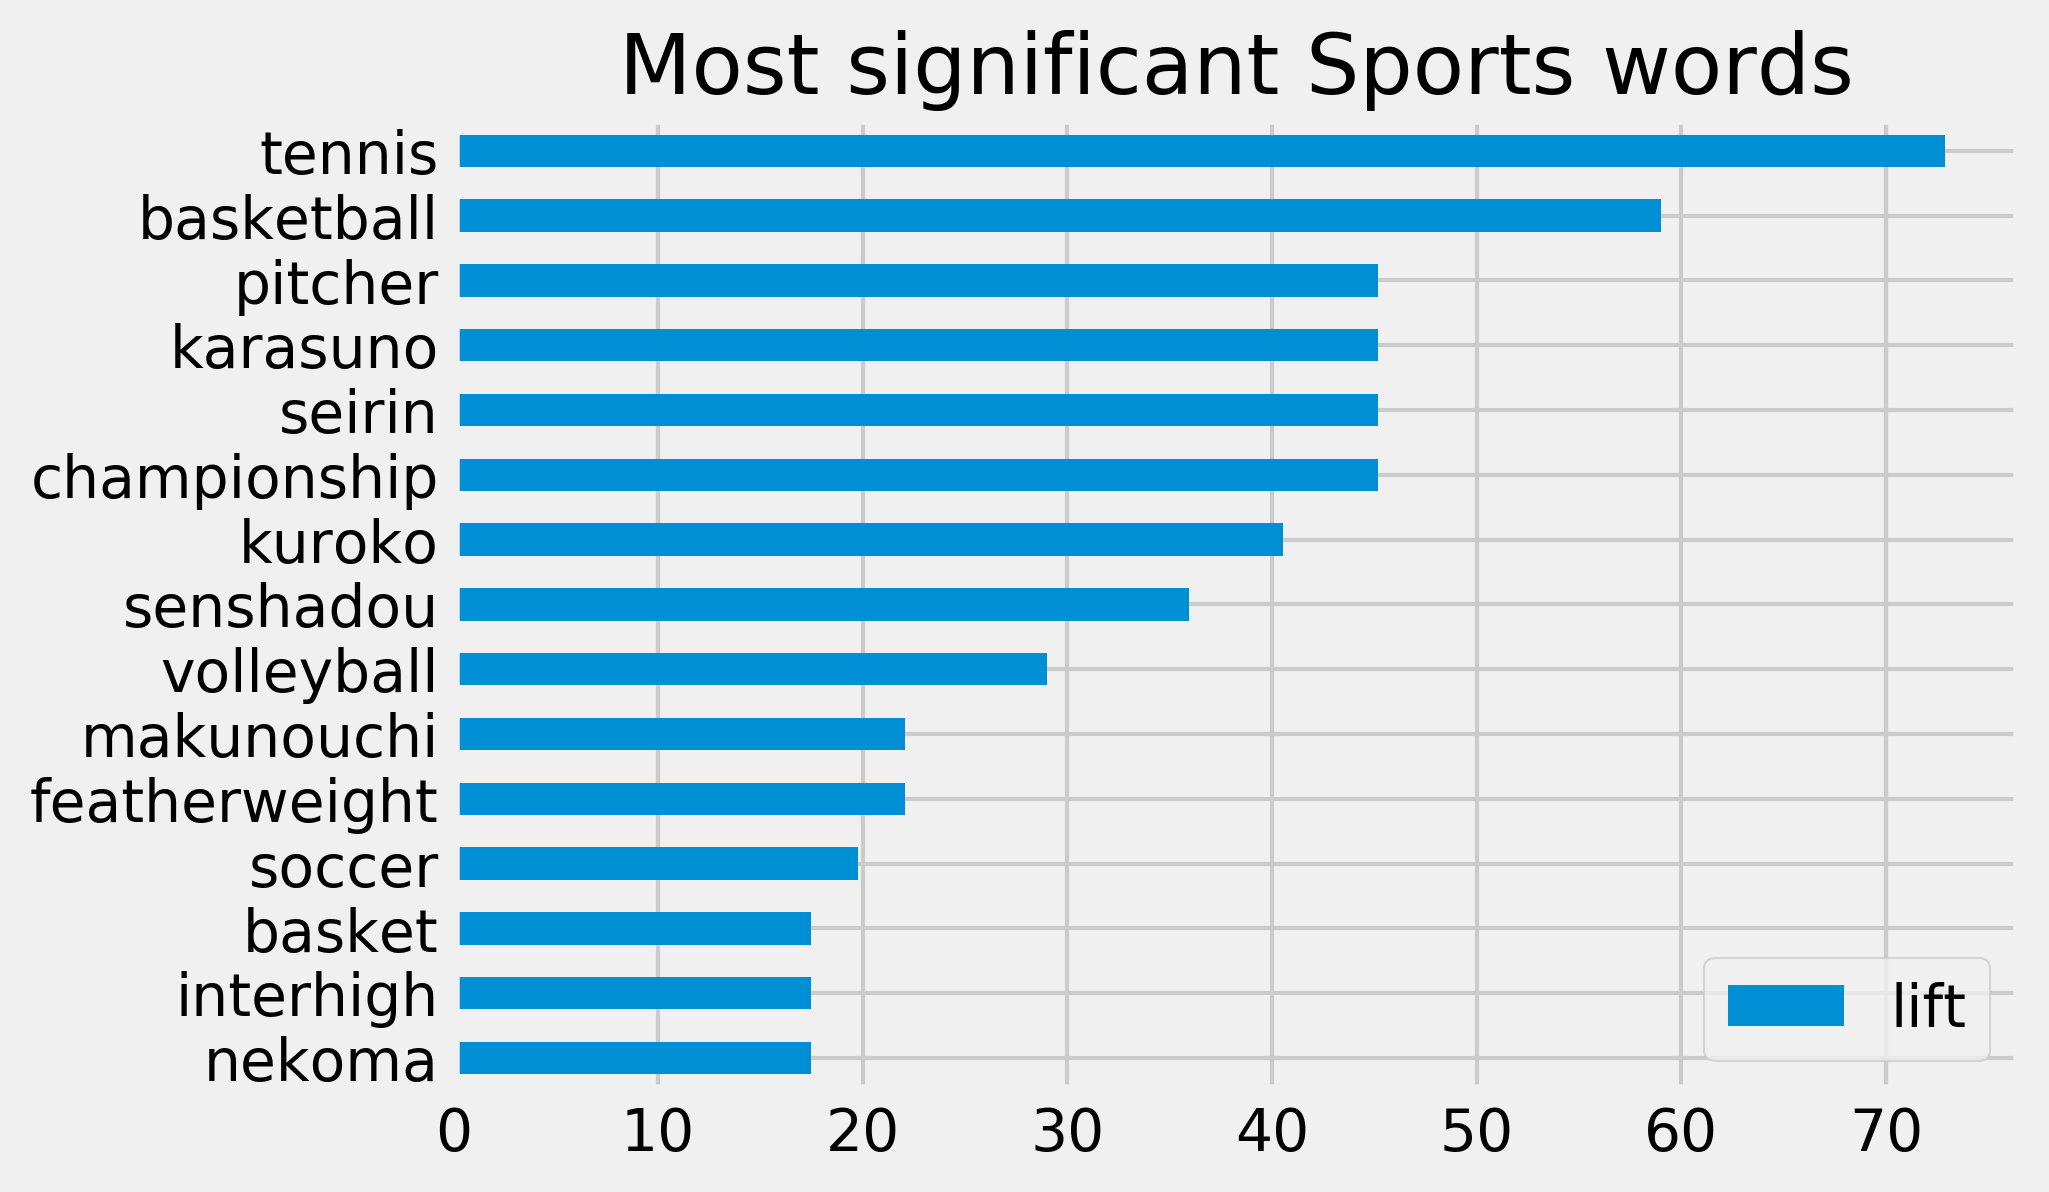

In [227]:
plot_best_words_of_genre("Sports")

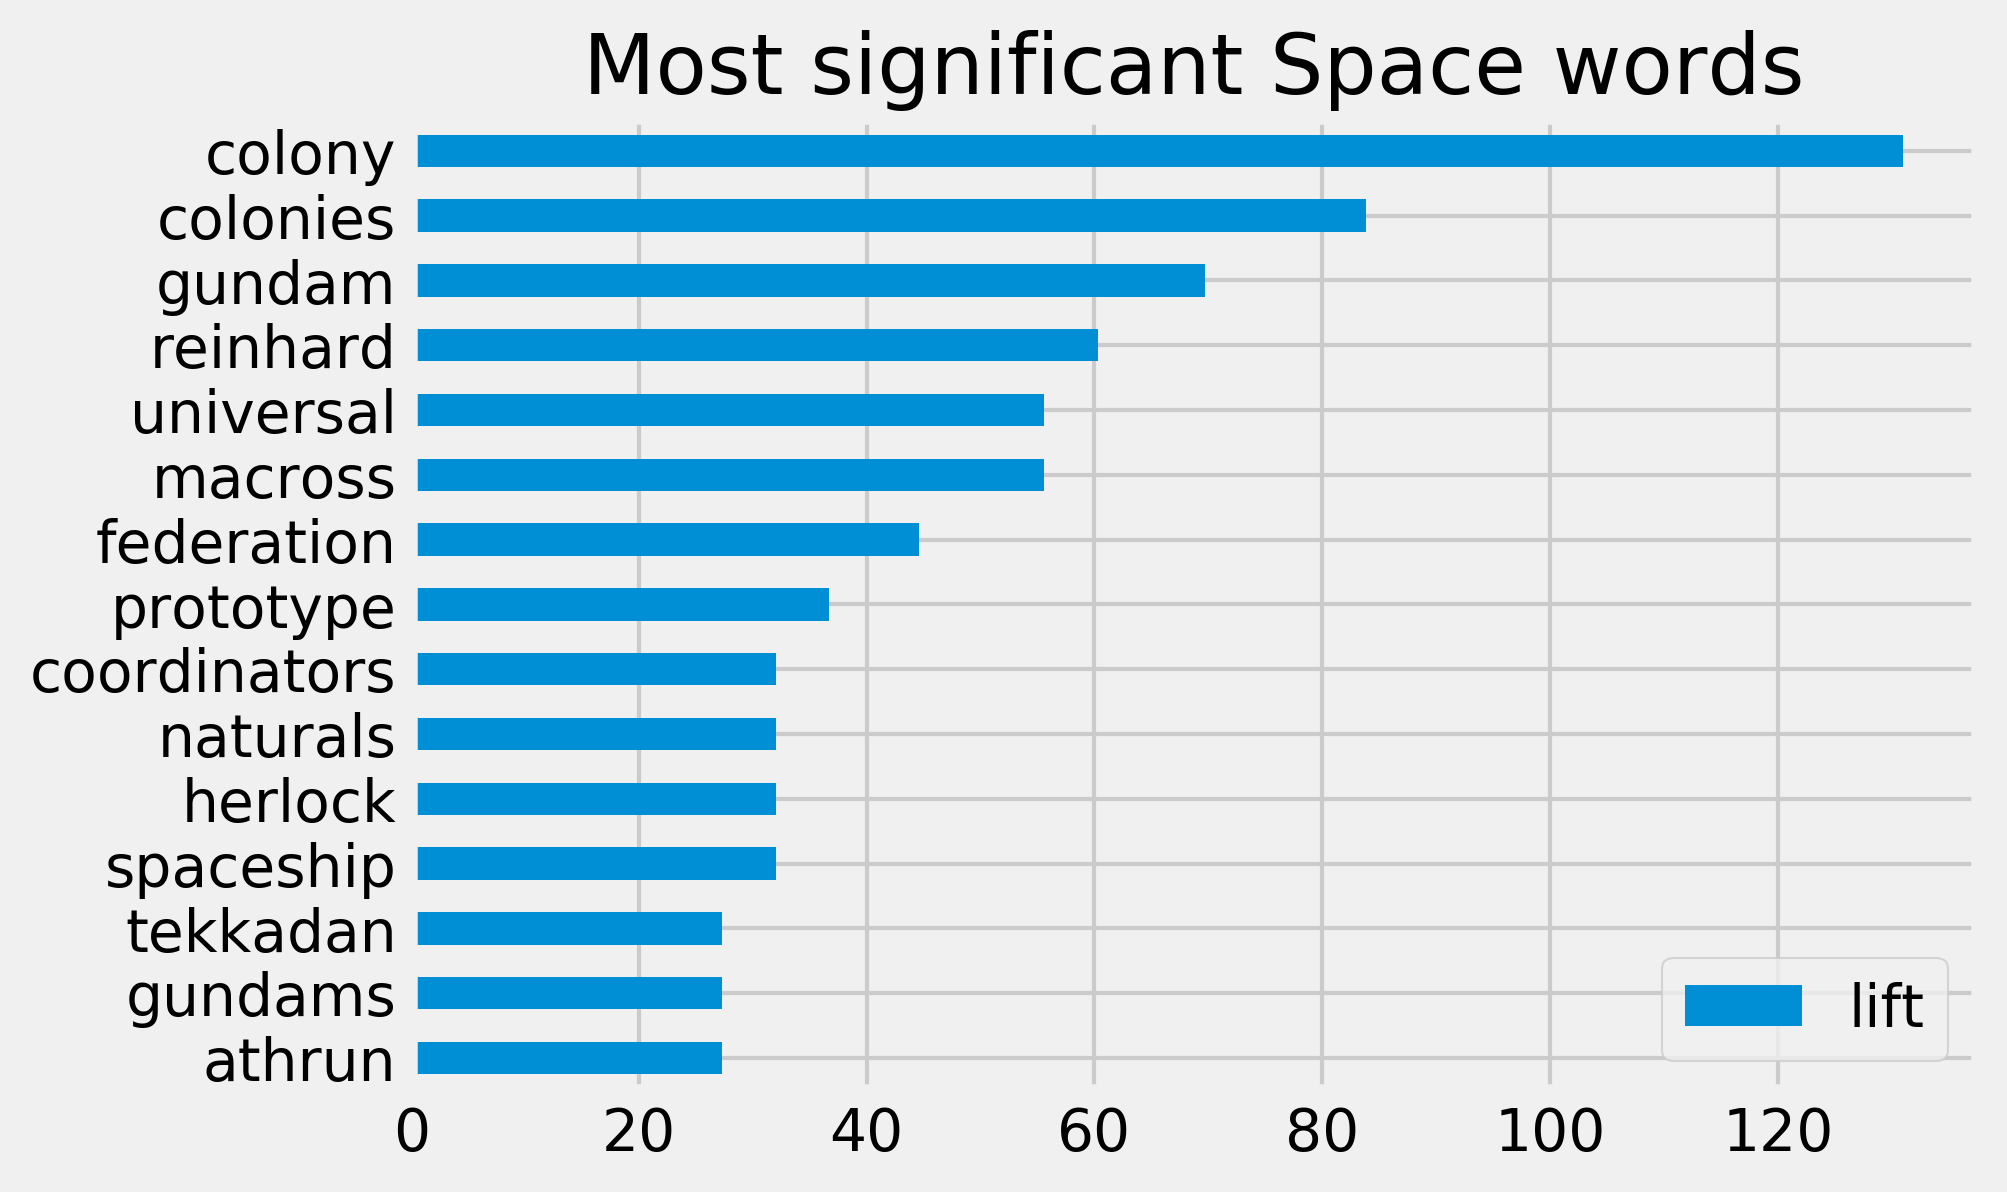

In [225]:
plot_best_words_of_genre("Space")

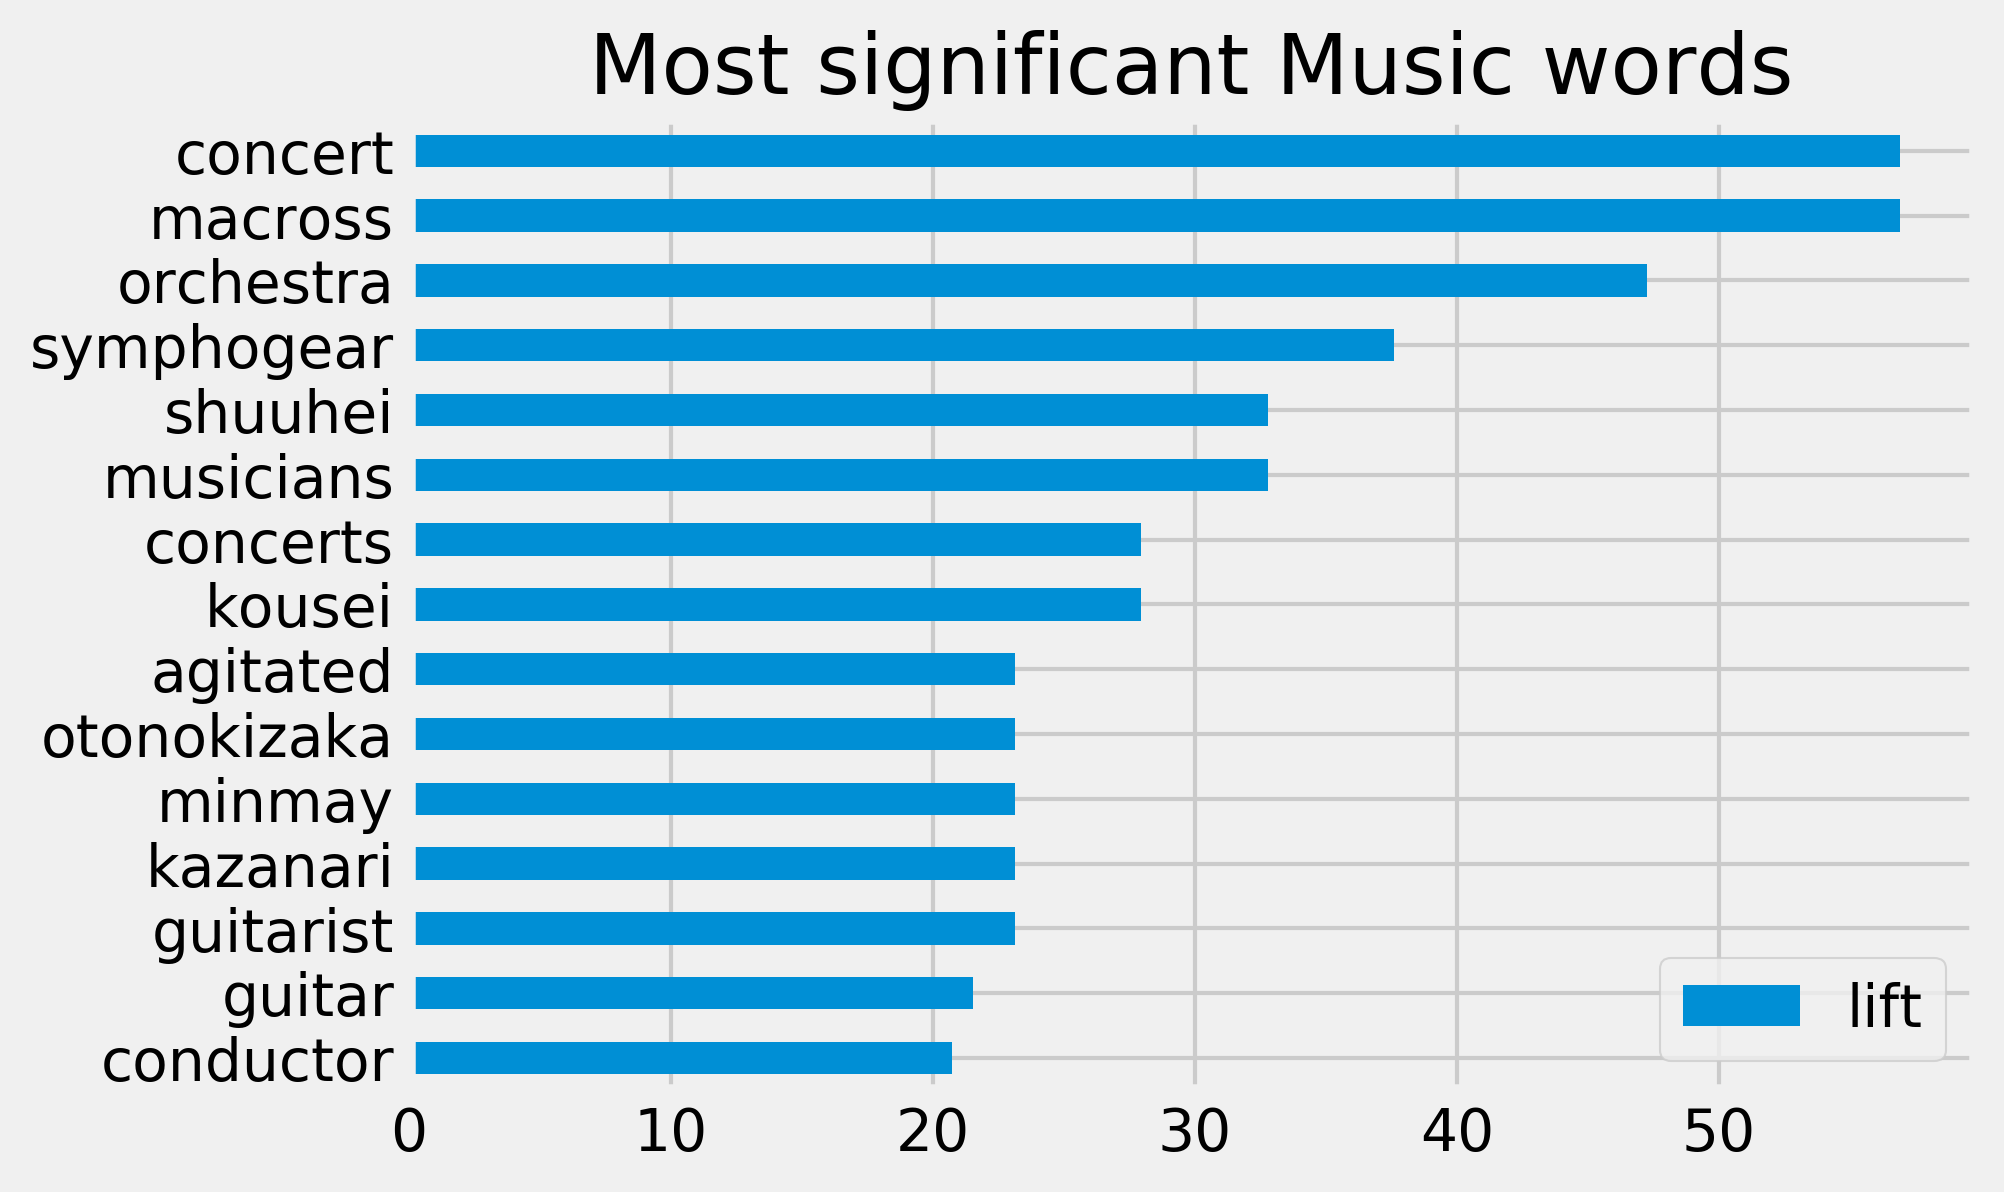

In [226]:
plot_best_words_of_genre("Music")

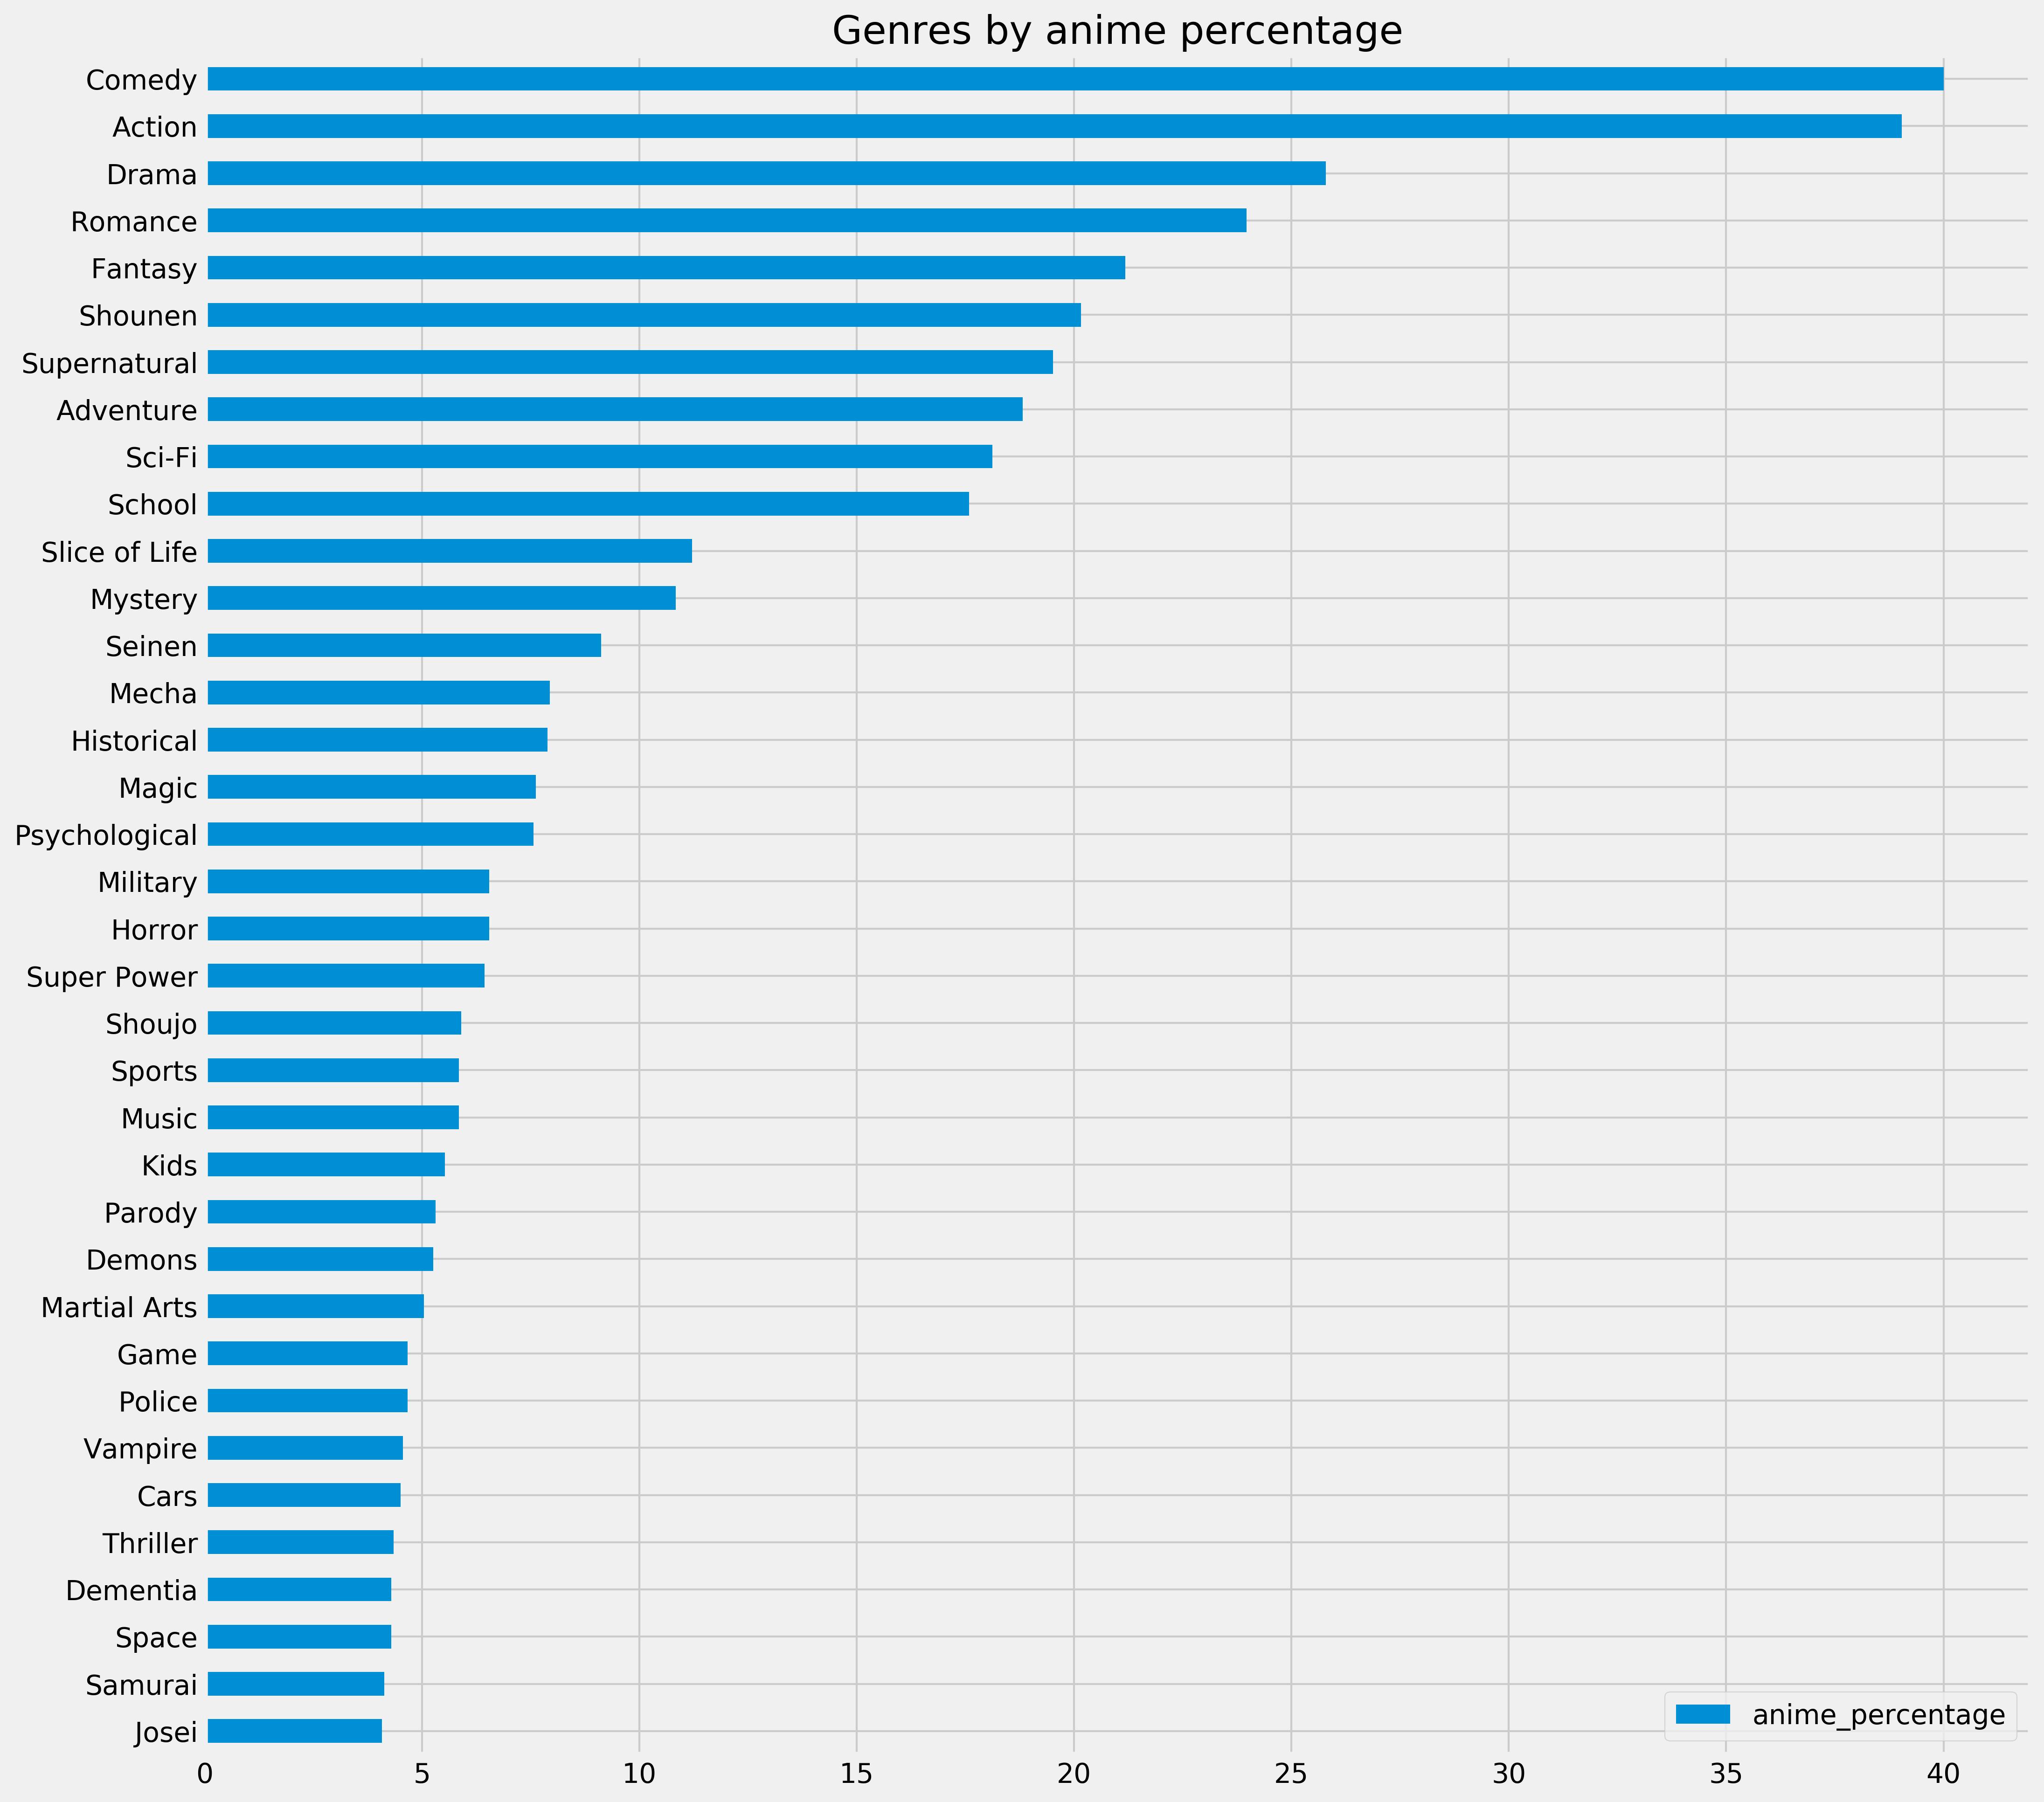

In [24]:
isolated_test_set[isolated_test_set["predicted_perfectly"] == True]

,title,synopsis,genres,Kids,Slice of Life,Demons,Shoujo,Harem,Yaoi,Mystery,School,Adventure,Game,Supernatural,Josei,Cars,Romance,Music,Vampire,Drama,Comedy,Parody,Shounen,Military,Dementia,...,Sci-Fi_prediction,Sci-Fi_prediction_is_accurate,Shoujo Ai_prediction,Shoujo Ai_prediction_is_accurate,Magic_prediction,Magic_prediction_is_accurate,Super Power_prediction,Super Power_prediction_is_accurate,Psychological_prediction,Psychological_prediction_is_accurate,Thriller_prediction,Thriller_prediction_is_accurate,Ecchi_prediction,Ecchi_prediction_is_accurate,Mecha_prediction,Mecha_prediction_is_accurate,Yuri_prediction,Yuri_prediction_is_accurate,Sports_prediction,Sports_prediction_is_accurate,Martial Arts_prediction,Martial Arts_prediction_is_accurate,accuracy,predicted_perfectly,prediction_score
52,Mobile Suit Gundam Wing: Endless Waltz,"[colony, conclusion, intergalactic, stasis, pr...","[Action, Drama, Mecha, Military, Sci-Fi, Space]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,...,True,True,False,True,False,True,False,True,False,True,False,True,False,True,True,True,False,True,False,True,False,True,100.0,True,1.0
78,Sekirei: Pure Engagement,"[second, battle, royale, sekirei, underway, cl...","[Action, Harem, Comedy, Super Power, Ecchi]",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,True,False,True,False,True,True,True,False,True,False,True,True,True,False,True,False,True,False,True,False,True,100.0,True,1.0
105,Natsume Yuujinchou,"[fifteen, another, harbor, secrets, related, t...","[Slice of Life, Demons, Supernatural, Drama, S...",False,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,100.0,True,1.0
141,Working!!!,"[stories, connected, wagnaria, certain, workpl...","[Comedy, Romance, Seinen, Slice of Life]",False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,100.0,True,1.0
146,Pokemon Best Wishes!,"[advanced, generation, diamond, series, before...","[Action, Adventure, Comedy, Fantasy, Kids]",True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,100.0,True,1.0
164,Break Blade 1: Kakusei no Toki,"[continent, cruzon, impending, between, kingdo...","[Action, Fantasy, Mecha, Military, Shounen]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,True,True,False,True,False,True,False,True,100.0,True,1.0
183,JoJo no Kimyou na Bouken Part 3: Stardust Crus...,"[ancient, salvaged, depths, joutarou, kuujou, ...","[Action, Adventure, Supernatural, Drama, Shounen]",False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,100.0,True,1.0
184,Pokemon: Mewtwo! Ware wa Koko ni Ari,"[rocket, leader, giovanni, mewtwo, remote, reg...","[Action, Adventure, Comedy, Drama, Fantasy, Kids]",True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,1

5.319672131147541